In [3]:
import os
import os.path as osp
def find_root_folder(starting_path = os.getcwd()):
    from os.path import isfile, join, dirname
    path = starting_path
    i = 0
    found = False
    while i < 100:
        found = ('LICENSE' in [f for f in os.listdir(path) if isfile(join(path, f))])
        if found:
            break
        else:
            i += 1
            path = dirname(path)            
    if found:
        print(f"Found directory with license at {path}")
    else:
        raise FileNotFoundError("Could not find LICENSE file in ancestral directory")
    return path
ROOT_FOLDER = find_root_folder()
DS_FOLDER = osp.join(ROOT_FOLDER,'kddbr-2022')


# Arguments. Some are unused
DEVICE = 'cuda'
FOLD_SPLITS = 10
WHICH_VAL_FOLD = 0
RANDOM_STATE = 123
DEBUG = False
BATCH_SIZE = 128
NUM_EPOCHS = 200
VAL_EPOCH = 5



Found directory with license at /home/klaus/eclipse_draft


In [2]:
import os

import cv2 as cv
import torch
import pandas as pd
import os.path as osp
import numpy as np
import torchvision
from torchvision.transforms import Normalize
from torch import tensor
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

"""
Dataframe setup
"""
import sklearn
from sklearn.model_selection import KFold
def setup_dataframes():
    df = pd.read_csv(osp.join(DS_FOLDER, 'public.csv'))
    df_test, df_train = df[pd.isna(df.East)].reset_index(drop=True), df[~pd.isna(df.East)].reset_index(drop=True)
    df_trainval = df_train.copy()
    del df
    # Use K-Fold to separate between training and test
    kf = KFold(n_splits=FOLD_SPLITS,shuffle=True,random_state=RANDOM_STATE)
    N_trainval = df_train.shape[0]
    for i,(train_idx, val_idx) in enumerate(kf.split(np.arange(N_trainval)[:,None])):
        if i == WHICH_VAL_FOLD:
            df_val = df_train.loc[val_idx,:].reset_index(drop=True)
            df_train = df_train.loc[train_idx,:].reset_index(drop=True)

    return {'train': df_train, 'val':df_val, 'test':df_test, 'trainval':df_trainval}


#  Get Dataframe dictionary
dfs = setup_dataframes()


In [3]:
display(dfs['test'])

,Filename,Altitude,Delta,North,East
0,000053b1e684c9e7ea73727b2238ce18.jpg,167.943069,0.010269,NaN,NaN
1,00029153d12ae1c9abe59c17ff2e0895.jpg,195.853088,0.089218,NaN,NaN
2,0006246bee639c7a7b11a08e34dd3cc6.jpg,146.943466,-0.018326,NaN,NaN
3,00063cb5da1826febf178b669eea3250.jpg,213.184418,-0.108704,NaN,NaN
4,00063ece2e68a8847f228e8fd922f851.jpg,184.757767,0.017700,NaN,NaN
...,...,...,...,...,...
55026,fff87fc38496c1838a216c742e653065.jpg,191.309677,-0.509415,NaN,NaN
55027,fff98e721ed96517d940eb5b2daf2d18.jpg,171.288254,0.109970,NaN,NaN
55028,fff9e3be29d11366c43df7b2ae749547.jpg,196.589905,-0.118561,NaN,NaN
55029,fffae68750a8bd5e6ba46b25ce7030de.jpg,176.795364,0.023209,NaN,NaN


/tmp/ipykernel_35551/4148619306.py:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  feat_df = pd.concat([pd.read_csv(osp.join(DS_FOLDER, 'features',sub, f'{mode}.csv')) for sub in sub_names],1)


,Unnamed: 0,Filename,Altitude,Delta,North,East,step,diff,NewAlt,step_is_neg
0,59522,a74d1ff33e951286f8b41bd995f0c5e0.jpg,166.561401,0.140137,-1.472750,1.073440,-1,0.000000,166.701538,1.0
1,50788,8eee11ee7ca63d411e87ee6a74745788.jpg,224.052460,-0.058441,-0.059471,0.650216,-1,0.000000,223.994019,1.0
2,50948,8f55c4078dea0f611692ed797b76d511.jpg,182.064758,0.116028,0.260522,0.070070,-1,0.000000,182.180786,1.0
3,51018,8f861a68d4d8f8ba0125e0a1a658b9c7.jpg,230.827515,0.081451,-1.165959,0.941549,-1,0.000000,230.908966,1.0
4,36116,655c4f29723a697c4873fbbdc66ddbdf.jpg,223.877167,-0.060501,-0.057968,0.670597,-1,0.000000,223.816666,1.0
...,...,...,...,...,...,...,...,...,...,...
91226,21588,3c2a0c5e5ecf4c43f503e936bb8e70f3.jpg,174.220734,0.118698,1.010115,0.593155,91137,0.222748,174.339432,0.0
91227,74228,d10bcc3e56fbc08cd7d07e74314ed528.jpg,174.058472,0.162262,0.893986,0.754980,91138,0.280960,174.220734,0.0
91228,90537,fe0ee9a28fabdb1c977ceca9c473b4ff.jpg,173.841064,0.217407,0.722605,0.654151,91139,0.379669,174.058472,0.0
91229,8029,1647786da9f34e8690fbd08db3484ad1.jpg,173.497986,0.343079,0.817771,0.129055,91140,0.560486,173.841064,0.0


,Altitude,Delta,diff,step_is_neg,pdcplus_mat_0,pdcplus_mat_1,pdcplus_mat_2,pdcplus_mat_3,pdcplus_mat_4,pdcplus_mat_5,...,GLUNet_GOCor_cm_mean,GLUNet_GOCor_ef0_mean,GLUNet_GOCor_ef0_std,GLUNet_GOCor_ef1_mean,GLUNet_GOCor_ef1_std,GLUNet_GOCor_cm_q0,GLUNet_GOCor_cm_q1,GLUNet_GOCor_cm_q2,GLUNet_GOCor_cm_q3,GLUNet_GOCor_cm_q4
0,166.561401,0.140137,0.000000,1.0,1.017574,0.191064,-22.708095,-0.167219,1.018105,2.783692,...,0.736023,10.463993,6.135418,9.923465,6.456117,0.033105,0.046751,0.752406,0.877969,0.998777
1,224.052460,-0.058441,0.000000,1.0,1.022570,0.010757,-4.170725,0.003817,1.010269,-0.696179,...,0.833583,2.447061,0.510309,0.179515,0.226978,0.257679,0.766619,0.804162,0.846109,0.997913
2,182.064758,0.116028,0.000000,1.0,0.985609,0.009227,-1.110656,-0.020233,0.938019,7.951728,...,0.764307,1.451570,0.951958,-3.916727,2.564897,0.075126,0.243526,0.765274,0.853063,0.999267
3,230.827515,0.081451,0.000000,1.0,1.066033,-0.047876,-6.477124,0.098423,1.078089,-29.447291,...,0.675097,9.828259,2.718860,20.800787,2.930892,0.032386,0.037510,0.135534,0.875181,0.999081
4,223.877167,-0.060501,0.000000,1.0,1.019876,0.010012,-3.814227,0.002843,1.008857,-0.605949,...,0.835902,2.255130,0.411887,0.271534,0.102971,0.293722,0.752783,0.809725,0.853496,0.999278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91226,174.220734,0.118698,0.222748,0.0,0.996849,-0.060377,-2.018381,0.056155,0.983116,5.701247,...,0.784183,5.351024,1.871278,-8.756925,1.783281,0.065982,0.103465,0.809721,0.894518,0.998990
91227,174.058472,0.162262,0.280960,0.0,0.998272,-0.026902,-5.124142,0.022658,0.976252,11.230693,...,0.744984,6.568175,0.586787,-12.128474,0.695420,0.057119,0.065586,0.775172,0.888422,0.998357
91228,173.841064,0.217407,0.379669,0.0,0.987939,0.146681,-16.975287,-0.149566,0.949875,27.178070,...,0.703530,11.630901,6.046025,-14.546108,5.869273,0.030028,0.038623,0.694534,0.887743,0.999225
91229,173.497986,0.343079,0.560486,0.0,1.002941,0.054704,-16.158076,-0.052108,0.960160,19.534451,...,0.685152,14.197543,2.853527,-13.943806,2.687752,0.036942,0.040848,0.634390,0.878711,0.998813


,Altitude,Delta,diff,step_is_neg,pdcplus_mat_0,pdcplus_mat_1,pdcplus_mat_2,pdcplus_mat_3,pdcplus_mat_4,pdcplus_mat_5,...,GLUNet_GOCor_cm_mean,GLUNet_GOCor_ef0_mean,GLUNet_GOCor_ef0_std,GLUNet_GOCor_ef1_mean,GLUNet_GOCor_ef1_std,GLUNet_GOCor_cm_q0,GLUNet_GOCor_cm_q1,GLUNet_GOCor_cm_q2,GLUNet_GOCor_cm_q3,GLUNet_GOCor_cm_q4
0,224.052460,-0.058441,0.000000,1.0,1.022570,0.010757,-4.170725,0.003817,1.010269,-0.696179,...,0.833583,2.447061,0.510309,0.179515,0.226978,0.257679,0.766619,0.804162,0.846109,0.997913
1,182.064758,0.116028,0.000000,1.0,0.985609,0.009227,-1.110656,-0.020233,0.938019,7.951728,...,0.764307,1.451570,0.951958,-3.916727,2.564897,0.075126,0.243526,0.765274,0.853063,0.999267
2,230.827515,0.081451,0.000000,1.0,1.066033,-0.047876,-6.477124,0.098423,1.078089,-29.447291,...,0.675097,9.828259,2.718860,20.800787,2.930892,0.032386,0.037510,0.135534,0.875181,0.999081
3,223.877167,-0.060501,0.000000,1.0,1.019876,0.010012,-3.814227,0.002843,1.008857,-0.605949,...,0.835902,2.255130,0.411887,0.271534,0.102971,0.293722,0.752783,0.809725,0.853496,0.999278
4,225.771179,0.047897,0.000000,1.0,1.010322,0.041972,1.916067,-0.019599,1.034531,-14.760870,...,0.730514,-4.396517,0.819240,15.260664,1.061261,0.049182,0.053765,0.767599,0.868530,0.998099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91226,174.058472,0.162262,0.280960,0.0,0.998272,-0.026902,-5.124142,0.022658,0.976252,11.230693,...,0.744984,6.568175,0.586787,-12.128474,0.695420,0.057119,0.065586,0.775172,0.888422,0.998357
91227,173.841064,0.217407,0.379669,0.0,0.987939,0.146681,-16.975287,-0.149566,0.949875,27.178070,...,0.703530,11.630901,6.046025,-14.546108,5.869273,0.030028,0.038623,0.694534,0.887743,0.999225
91228,173.497986,0.343079,0.560486,0.0,1.002941,0.054704,-16.158076,-0.052108,0.960160,19.534451,...,0.685152,14.197543,2.853527,-13.943806,2.687752,0.036942,0.040848,0.634390,0.878711,0.998813
91229,161.743301,0.234360,0.234360,0.0,0.994880,0.001014,5.551046,0.001034,0.993946,-2.034456,...,0.833339,-5.328970,0.256574,2.196662,0.166793,0.133711,0.728649,0.818972,0.890431,0.999230


,Altitude,Delta,diff,step_is_neg,pdcplus_mat_0,pdcplus_mat_1,pdcplus_mat_2,pdcplus_mat_3,pdcplus_mat_4,pdcplus_mat_5,...,GLUNet_GOCor_cm_mean,GLUNet_GOCor_ef0_mean,GLUNet_GOCor_ef0_std,GLUNet_GOCor_ef1_mean,GLUNet_GOCor_ef1_std,GLUNet_GOCor_cm_q0,GLUNet_GOCor_cm_q1,GLUNet_GOCor_cm_q2,GLUNet_GOCor_cm_q3,GLUNet_GOCor_cm_q4
0,182.064758,0.116028,0.000000,1.0,0.985609,0.009227,-1.110656,-0.020233,0.938019,7.951728,...,0.764307,1.451570,0.951958,-3.916727,2.564897,0.075126,0.243526,0.765274,0.853063,0.999267
1,230.827515,0.081451,0.000000,1.0,1.066033,-0.047876,-6.477124,0.098423,1.078089,-29.447291,...,0.675097,9.828259,2.718860,20.800787,2.930892,0.032386,0.037510,0.135534,0.875181,0.999081
2,223.877167,-0.060501,0.000000,1.0,1.019876,0.010012,-3.814227,0.002843,1.008857,-0.605949,...,0.835902,2.255130,0.411887,0.271534,0.102971,0.293722,0.752783,0.809725,0.853496,0.999278
3,225.771179,0.047897,0.000000,1.0,1.010322,0.041972,1.916067,-0.019599,1.034531,-14.760870,...,0.730514,-4.396517,0.819240,15.260664,1.061261,0.049182,0.053765,0.767599,0.868530,0.998099
4,214.608871,0.026794,0.000000,1.0,1.050596,-0.060952,-1.259243,0.104265,1.068994,-28.126155,...,0.721165,6.086092,3.165088,19.702658,3.251760,0.034627,0.041516,0.747843,0.906426,0.999109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91226,173.841064,0.217407,0.379669,0.0,0.987939,0.146681,-16.975287,-0.149566,0.949875,27.178070,...,0.703530,11.630901,6.046025,-14.546108,5.869273,0.030028,0.038623,0.694534,0.887743,0.999225
91227,173.497986,0.343079,0.560486,0.0,1.002941,0.054704,-16.158076,-0.052108,0.960160,19.534451,...,0.685152,14.197543,2.853527,-13.943806,2.687752,0.036942,0.040848,0.634390,0.878711,0.998813
91228,161.743301,0.234360,0.234360,0.0,0.994880,0.001014,5.551046,0.001034,0.993946,-2.034456,...,0.833339,-5.328970,0.256574,2.196662,0.166793,0.133711,0.728649,0.818972,0.890431,0.999230
91229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_35551/4148619306.py:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  feat_df = pd.concat([pd.read_csv(osp.join(DS_FOLDER, 'features',sub, f'{mode}.csv')) for sub in sub_names],1)


,Unnamed: 0,Filename,Altitude,Delta,North,East,step,diff,NewAlt,step_is_neg
0,12317,3922314b8050f8c35ef91dacb6ec72a1.jpg,230.478577,-0.290161,NaN,NaN,-1,0.000000,230.188416,1.0
1,29385,88903f12da23bba2fe342982583e7993.jpg,188.860229,-0.075989,NaN,NaN,-1,0.000000,188.784241,1.0
2,23469,6d12d67f199260c85d1fdafc0ebe4395.jpg,183.928680,0.421219,NaN,NaN,-1,0.000000,184.349899,1.0
3,19198,58d5e97be4ccb06f4d68092db08ec5be.jpg,178.813446,-0.059631,NaN,NaN,-1,0.000000,178.753815,1.0
4,39142,b6225444f2560ba859c24a14ccd9769c.jpg,212.381531,-0.170593,NaN,NaN,-1,0.000000,212.210938,1.0
...,...,...,...,...,...,...,...,...,...,...
55026,54107,fb7fce873c18ddcc4625ce2e9fa064ab.jpg,178.577438,-0.019058,NaN,NaN,54942,0.000000,178.558380,0.0
55027,425,01e91c5fa75d1dac67001b11e1d34526.jpg,178.558380,-0.017242,NaN,NaN,54943,0.000000,178.541138,0.0
55028,25626,773dba6697ae13585ea0dc4b8b19bc8b.jpg,178.541138,-0.012421,NaN,NaN,54944,0.000000,178.528717,0.0
55029,894,04215c1ad3aaff3ed175446d2ea3c0f2.jpg,178.528717,-0.013397,NaN,NaN,54945,0.000000,178.515320,0.0


,Altitude,Delta,diff,step_is_neg,pdcplus_mat_0,pdcplus_mat_1,pdcplus_mat_2,pdcplus_mat_3,pdcplus_mat_4,pdcplus_mat_5,...,GLUNet_GOCor_cm_mean,GLUNet_GOCor_ef0_mean,GLUNet_GOCor_ef0_std,GLUNet_GOCor_ef1_mean,GLUNet_GOCor_ef1_std,GLUNet_GOCor_cm_q0,GLUNet_GOCor_cm_q1,GLUNet_GOCor_cm_q2,GLUNet_GOCor_cm_q3,GLUNet_GOCor_cm_q4
0,230.478577,-0.290161,0.000000,1.0,1.011894,-0.004143,-3.880650,0.005814,1.003889,-2.157535,...,0.860559,3.613659,0.383816,1.772314,0.139648,0.146877,0.742049,0.847633,0.904273,0.999715
1,188.860229,-0.075989,0.000000,1.0,1.061821,-0.039317,-30.428207,-0.011323,0.977308,1.792325,...,0.666144,26.826811,2.411234,-0.840706,0.343785,0.036158,0.039206,0.569561,0.832496,0.996975
2,183.928680,0.421219,0.000000,1.0,1.062192,0.159616,-51.698545,0.052281,1.090239,-23.954553,...,0.301256,36.892006,3.964749,16.454462,2.503451,0.021402,0.023395,0.024738,0.118267,0.997480
3,178.813446,-0.059631,0.000000,1.0,1.000770,-0.009429,-1.335664,-0.000651,1.069730,20.819601,...,0.692409,1.688640,0.228250,-23.473721,2.460784,0.035649,0.047433,0.691777,0.837889,0.999140
4,212.381531,-0.170593,0.000000,1.0,1.033439,0.071052,-4.098144,-0.047691,1.059311,-21.841621,...,0.717793,-1.472914,1.505020,22.435881,1.654367,0.036598,0.041230,0.756687,0.892301,0.998344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55026,178.577438,-0.019058,0.000000,0.0,0.911372,-0.017899,0.052411,-0.016448,0.673521,34.669055,...,0.415132,2.689565,1.384993,-27.369623,7.827008,0.026419,0.028422,0.032593,0.488727,0.996144
55027,178.558380,-0.017242,0.000000,0.0,0.908090,0.043597,-1.635899,-0.022545,0.974698,34.368953,...,0.250255,-1.893308,7.120929,-22.985052,9.156836,0.025002,0.035033,0.048500,0.088151,0.985467
55028,178.541138,-0.012421,0.000000,0.0,0.836551,0.108279,0.120309,-0.011358,1.131215,48.969717,...,0.124747,-2.142629,5.383683,-15.092348,14.150483,0.027624,0.039621,0.049298,0.082617,0.955448
55029,178.528717,-0.013397,0.000000,0.0,1.136385,-0.380647,-7.994865,-0.299410,0.872686,5.500082,...,0.086051,2.436351,5.394520,4.009822,7.337147,0.023059,0.048509,0.057177,0.070030,0.786913


,Altitude,Delta,diff,step_is_neg,pdcplus_mat_0,pdcplus_mat_1,pdcplus_mat_2,pdcplus_mat_3,pdcplus_mat_4,pdcplus_mat_5,...,GLUNet_GOCor_cm_mean,GLUNet_GOCor_ef0_mean,GLUNet_GOCor_ef0_std,GLUNet_GOCor_ef1_mean,GLUNet_GOCor_ef1_std,GLUNet_GOCor_cm_q0,GLUNet_GOCor_cm_q1,GLUNet_GOCor_cm_q2,GLUNet_GOCor_cm_q3,GLUNet_GOCor_cm_q4
0,188.860229,-0.075989,0.000000,1.0,1.061821,-0.039317,-30.428207,-0.011323,0.977308,1.792325,...,0.666144,26.826811,2.411234,-0.840706,0.343785,0.036158,0.039206,0.569561,0.832496,0.996975
1,183.928680,0.421219,0.000000,1.0,1.062192,0.159616,-51.698545,0.052281,1.090239,-23.954553,...,0.301256,36.892006,3.964749,16.454462,2.503451,0.021402,0.023395,0.024738,0.118267,0.997480
2,178.813446,-0.059631,0.000000,1.0,1.000770,-0.009429,-1.335664,-0.000651,1.069730,20.819601,...,0.692409,1.688640,0.228250,-23.473721,2.460784,0.035649,0.047433,0.691777,0.837889,0.999140
3,212.381531,-0.170593,0.000000,1.0,1.033439,0.071052,-4.098144,-0.047691,1.059311,-21.841621,...,0.717793,-1.472914,1.505020,22.435881,1.654367,0.036598,0.041230,0.756687,0.892301,0.998344
4,227.722183,-0.267853,0.000000,1.0,1.004792,-0.003264,-2.443644,0.002614,0.999546,-1.299404,...,0.860718,2.225972,0.222541,1.233041,0.097477,0.202518,0.772544,0.843440,0.889870,0.999168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55026,178.558380,-0.017242,0.000000,0.0,0.908090,0.043597,-1.635899,-0.022545,0.974698,34.368953,...,0.250255,-1.893308,7.120929,-22.985052,9.156836,0.025002,0.035033,0.048500,0.088151,0.985467
55027,178.541138,-0.012421,0.000000,0.0,0.836551,0.108279,0.120309,-0.011358,1.131215,48.969717,...,0.124747,-2.142629,5.383683,-15.092348,14.150483,0.027624,0.039621,0.049298,0.082617,0.955448
55028,178.528717,-0.013397,0.000000,0.0,1.136385,-0.380647,-7.994865,-0.299410,0.872686,5.500082,...,0.086051,2.436351,5.394520,4.009822,7.337147,0.023059,0.048509,0.057177,0.070030,0.786913
55029,147.411255,0.010345,0.010345,0.0,0.983504,-0.002484,16.642738,0.008264,1.004556,-14.503930,...,0.688027,-15.611630,0.645519,13.878342,0.366320,0.042641,0.044189,0.624922,0.884954,0.999792


,Altitude,Delta,diff,step_is_neg,pdcplus_mat_0,pdcplus_mat_1,pdcplus_mat_2,pdcplus_mat_3,pdcplus_mat_4,pdcplus_mat_5,...,GLUNet_GOCor_cm_mean,GLUNet_GOCor_ef0_mean,GLUNet_GOCor_ef0_std,GLUNet_GOCor_ef1_mean,GLUNet_GOCor_ef1_std,GLUNet_GOCor_cm_q0,GLUNet_GOCor_cm_q1,GLUNet_GOCor_cm_q2,GLUNet_GOCor_cm_q3,GLUNet_GOCor_cm_q4
0,183.928680,0.421219,0.000000,1.0,1.062192,0.159616,-51.698545,0.052281,1.090239,-23.954553,...,0.301256,36.892006,3.964749,16.454462,2.503451,0.021402,0.023395,0.024738,0.118267,0.997480
1,178.813446,-0.059631,0.000000,1.0,1.000770,-0.009429,-1.335664,-0.000651,1.069730,20.819601,...,0.692409,1.688640,0.228250,-23.473721,2.460784,0.035649,0.047433,0.691777,0.837889,0.999140
2,212.381531,-0.170593,0.000000,1.0,1.033439,0.071052,-4.098144,-0.047691,1.059311,-21.841621,...,0.717793,-1.472914,1.505020,22.435881,1.654367,0.036598,0.041230,0.756687,0.892301,0.998344
3,227.722183,-0.267853,0.000000,1.0,1.004792,-0.003264,-2.443644,0.002614,0.999546,-1.299404,...,0.860718,2.225972,0.222541,1.233041,0.097477,0.202518,0.772544,0.843440,0.889870,0.999168
4,175.315430,0.047714,0.000000,1.0,1.002384,0.001929,-0.493785,0.002473,0.993407,-5.387456,...,0.826230,0.632229,0.233789,6.057112,0.662772,0.104455,0.659515,0.817828,0.897526,0.998625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55026,178.541138,-0.012421,0.000000,0.0,0.836551,0.108279,0.120309,-0.011358,1.131215,48.969717,...,0.124747,-2.142629,5.383683,-15.092348,14.150483,0.027624,0.039621,0.049298,0.082617,0.955448
55027,178.528717,-0.013397,0.000000,0.0,1.136385,-0.380647,-7.994865,-0.299410,0.872686,5.500082,...,0.086051,2.436351,5.394520,4.009822,7.337147,0.023059,0.048509,0.057177,0.070030,0.786913
55028,147.411255,0.010345,0.010345,0.0,0.983504,-0.002484,16.642738,0.008264,1.004556,-14.503930,...,0.688027,-15.611630,0.645519,13.878342,0.366320,0.042641,0.044189,0.624922,0.884954,0.999792
55029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30897
[LightGBM] [Info] Number of data points in the train set: 82108, number of used features: 129
[LightGBM] [Info] Start training from score 0.008052
[1]	training's rmse: 1.19532	valid_1's rmse: 1.09787
[2]	training's rmse: 1.19016	valid_1's rmse: 1.09331
[3]	training's rmse: 1.185	valid_1's rmse: 1.08886
[4]	training's rmse: 1.17986	valid_1's rmse: 1.08424
[5]	training's rmse: 1.17476	valid_1's rmse: 1.07974
[6]	training's rmse: 1.16964	valid_1's rmse: 1.07506
[7]	training's rmse: 1.16457	valid_1's rmse: 1.07079
[8]	training's rmse: 1.15961	valid_1's rmse: 1.06708
[9]	training's rmse: 1.15462	valid_1's rmse: 1.06262
[10]	training's rmse: 1.14965	valid_1's rmse: 1.05836
[11]	training's rmse: 1.14468	valid_1's rmse: 1.05408
[12]	training's rmse: 1.13978	valid_1's rmse: 1.0

[173]	training's rmse: 0.619897	valid_1's rmse: 0.59824
[174]	training's rmse: 0.617945	valid_1's rmse: 0.596442
[175]	training's rmse: 0.616159	valid_1's rmse: 0.595362
[176]	training's rmse: 0.614242	valid_1's rmse: 0.593833
[177]	training's rmse: 0.612294	valid_1's rmse: 0.592141
[178]	training's rmse: 0.610359	valid_1's rmse: 0.590515
[179]	training's rmse: 0.608423	valid_1's rmse: 0.588838
[180]	training's rmse: 0.606562	valid_1's rmse: 0.587393
[181]	training's rmse: 0.604686	valid_1's rmse: 0.585651
[182]	training's rmse: 0.602813	valid_1's rmse: 0.583949
[183]	training's rmse: 0.600974	valid_1's rmse: 0.582258
[184]	training's rmse: 0.599122	valid_1's rmse: 0.58062
[185]	training's rmse: 0.597301	valid_1's rmse: 0.579096
[186]	training's rmse: 0.595525	valid_1's rmse: 0.577683
[187]	training's rmse: 0.593715	valid_1's rmse: 0.576059
[188]	training's rmse: 0.591911	valid_1's rmse: 0.57445
[189]	training's rmse: 0.590179	valid_1's rmse: 0.573157
[190]	training's rmse: 0.588413	va

[354]	training's rmse: 0.405498	valid_1's rmse: 0.408484
[355]	training's rmse: 0.404826	valid_1's rmse: 0.407744
[356]	training's rmse: 0.404211	valid_1's rmse: 0.40722
[357]	training's rmse: 0.403564	valid_1's rmse: 0.406499
[358]	training's rmse: 0.402955	valid_1's rmse: 0.40591
[359]	training's rmse: 0.402308	valid_1's rmse: 0.405211
[360]	training's rmse: 0.401643	valid_1's rmse: 0.404575
[361]	training's rmse: 0.401003	valid_1's rmse: 0.404009
[362]	training's rmse: 0.400387	valid_1's rmse: 0.403496
[363]	training's rmse: 0.399824	valid_1's rmse: 0.403242
[364]	training's rmse: 0.399202	valid_1's rmse: 0.402773
[365]	training's rmse: 0.398555	valid_1's rmse: 0.402208
[366]	training's rmse: 0.398004	valid_1's rmse: 0.401966
[367]	training's rmse: 0.397382	valid_1's rmse: 0.401421
[368]	training's rmse: 0.396831	valid_1's rmse: 0.40125
[369]	training's rmse: 0.396237	valid_1's rmse: 0.400807
[370]	training's rmse: 0.395627	valid_1's rmse: 0.40029
[371]	training's rmse: 0.39506	vali

[534]	training's rmse: 0.333654	valid_1's rmse: 0.348887
[535]	training's rmse: 0.333416	valid_1's rmse: 0.348614
[536]	training's rmse: 0.333172	valid_1's rmse: 0.348437
[537]	training's rmse: 0.332925	valid_1's rmse: 0.34822
[538]	training's rmse: 0.33268	valid_1's rmse: 0.347973
[539]	training's rmse: 0.332441	valid_1's rmse: 0.347761
[540]	training's rmse: 0.332207	valid_1's rmse: 0.347431
[541]	training's rmse: 0.331973	valid_1's rmse: 0.347233
[542]	training's rmse: 0.331734	valid_1's rmse: 0.347017
[543]	training's rmse: 0.331498	valid_1's rmse: 0.346792
[544]	training's rmse: 0.331258	valid_1's rmse: 0.34659
[545]	training's rmse: 0.331023	valid_1's rmse: 0.346374
[546]	training's rmse: 0.330779	valid_1's rmse: 0.346177
[547]	training's rmse: 0.330567	valid_1's rmse: 0.346105
[548]	training's rmse: 0.330337	valid_1's rmse: 0.345997
[549]	training's rmse: 0.330107	valid_1's rmse: 0.34585
[550]	training's rmse: 0.329863	valid_1's rmse: 0.345691
[551]	training's rmse: 0.329668	val

[679]	training's rmse: 0.306733	valid_1's rmse: 0.329013
[680]	training's rmse: 0.306601	valid_1's rmse: 0.328964
[681]	training's rmse: 0.306427	valid_1's rmse: 0.328858
[682]	training's rmse: 0.306283	valid_1's rmse: 0.328759
[683]	training's rmse: 0.306116	valid_1's rmse: 0.328679
[684]	training's rmse: 0.305965	valid_1's rmse: 0.328565
[685]	training's rmse: 0.30581	valid_1's rmse: 0.328432
[686]	training's rmse: 0.305683	valid_1's rmse: 0.328334
[687]	training's rmse: 0.305555	valid_1's rmse: 0.3283
[688]	training's rmse: 0.305431	valid_1's rmse: 0.328229
[689]	training's rmse: 0.305299	valid_1's rmse: 0.328148
[690]	training's rmse: 0.305182	valid_1's rmse: 0.328078
[691]	training's rmse: 0.305034	valid_1's rmse: 0.327966
[692]	training's rmse: 0.30487	valid_1's rmse: 0.327897
[693]	training's rmse: 0.304711	valid_1's rmse: 0.32781
[694]	training's rmse: 0.304565	valid_1's rmse: 0.327625
[695]	training's rmse: 0.304421	valid_1's rmse: 0.327541
[696]	training's rmse: 0.304287	vali

[832]	training's rmse: 0.288812	valid_1's rmse: 0.319116
[833]	training's rmse: 0.288721	valid_1's rmse: 0.319089
[834]	training's rmse: 0.288637	valid_1's rmse: 0.319085
[835]	training's rmse: 0.28855	valid_1's rmse: 0.319049
[836]	training's rmse: 0.288471	valid_1's rmse: 0.319023
[837]	training's rmse: 0.288398	valid_1's rmse: 0.318999
[838]	training's rmse: 0.288323	valid_1's rmse: 0.318951
[839]	training's rmse: 0.288246	valid_1's rmse: 0.318926
[840]	training's rmse: 0.288172	valid_1's rmse: 0.318874
[841]	training's rmse: 0.288075	valid_1's rmse: 0.318821
[842]	training's rmse: 0.287984	valid_1's rmse: 0.318843
[843]	training's rmse: 0.287884	valid_1's rmse: 0.31883
[844]	training's rmse: 0.287787	valid_1's rmse: 0.318808
[845]	training's rmse: 0.287695	valid_1's rmse: 0.318777
[846]	training's rmse: 0.287606	valid_1's rmse: 0.318753
[847]	training's rmse: 0.287515	valid_1's rmse: 0.318705
[848]	training's rmse: 0.287433	valid_1's rmse: 0.318694
[849]	training's rmse: 0.287351	v

[992]	training's rmse: 0.275359	valid_1's rmse: 0.314646
[993]	training's rmse: 0.27531	valid_1's rmse: 0.31464
[994]	training's rmse: 0.275249	valid_1's rmse: 0.314644
[995]	training's rmse: 0.275181	valid_1's rmse: 0.31463
[996]	training's rmse: 0.275109	valid_1's rmse: 0.314604
[997]	training's rmse: 0.275034	valid_1's rmse: 0.314589
[998]	training's rmse: 0.27496	valid_1's rmse: 0.314564
[999]	training's rmse: 0.274895	valid_1's rmse: 0.314547
[1000]	training's rmse: 0.274819	valid_1's rmse: 0.314532
[1001]	training's rmse: 0.274746	valid_1's rmse: 0.31453
[1002]	training's rmse: 0.27469	valid_1's rmse: 0.314517
[1003]	training's rmse: 0.274632	valid_1's rmse: 0.314522
[1004]	training's rmse: 0.274569	valid_1's rmse: 0.314534
[1005]	training's rmse: 0.274504	valid_1's rmse: 0.314517
[1006]	training's rmse: 0.274436	valid_1's rmse: 0.314476
[1007]	training's rmse: 0.274359	valid_1's rmse: 0.314431
[1008]	training's rmse: 0.274283	valid_1's rmse: 0.314358
[1009]	training's rmse: 0.27

[1151]	training's rmse: 0.264772	valid_1's rmse: 0.312681
[1152]	training's rmse: 0.264714	valid_1's rmse: 0.312646
[1153]	training's rmse: 0.264649	valid_1's rmse: 0.312645
[1154]	training's rmse: 0.264597	valid_1's rmse: 0.312665
[1155]	training's rmse: 0.264539	valid_1's rmse: 0.312653
[1156]	training's rmse: 0.264483	valid_1's rmse: 0.312648
[1157]	training's rmse: 0.264425	valid_1's rmse: 0.312645
[1158]	training's rmse: 0.264368	valid_1's rmse: 0.312644
[1159]	training's rmse: 0.264315	valid_1's rmse: 0.312636
[1160]	training's rmse: 0.264261	valid_1's rmse: 0.312629
[1161]	training's rmse: 0.26422	valid_1's rmse: 0.312626
[1162]	training's rmse: 0.264168	valid_1's rmse: 0.312622
[1163]	training's rmse: 0.26412	valid_1's rmse: 0.312615
[1164]	training's rmse: 0.264078	valid_1's rmse: 0.31262
[1165]	training's rmse: 0.264019	valid_1's rmse: 0.312597
[1166]	training's rmse: 0.263943	valid_1's rmse: 0.31259
[1167]	training's rmse: 0.263871	valid_1's rmse: 0.31259
[1168]	training's r

[1317]	training's rmse: 0.256062	valid_1's rmse: 0.311317
[1318]	training's rmse: 0.256021	valid_1's rmse: 0.311309
[1319]	training's rmse: 0.255985	valid_1's rmse: 0.311304
[1320]	training's rmse: 0.255951	valid_1's rmse: 0.311309
[1321]	training's rmse: 0.255914	valid_1's rmse: 0.311307
[1322]	training's rmse: 0.255877	valid_1's rmse: 0.311296
[1323]	training's rmse: 0.255844	valid_1's rmse: 0.311278
[1324]	training's rmse: 0.255795	valid_1's rmse: 0.311256
[1325]	training's rmse: 0.255758	valid_1's rmse: 0.311246
[1326]	training's rmse: 0.255708	valid_1's rmse: 0.31125
[1327]	training's rmse: 0.25565	valid_1's rmse: 0.311274
[1328]	training's rmse: 0.255596	valid_1's rmse: 0.311275
[1329]	training's rmse: 0.255539	valid_1's rmse: 0.311254
[1330]	training's rmse: 0.255479	valid_1's rmse: 0.311255
[1331]	training's rmse: 0.255438	valid_1's rmse: 0.311261
[1332]	training's rmse: 0.255391	valid_1's rmse: 0.311266
[1333]	training's rmse: 0.255353	valid_1's rmse: 0.311259
[1334]	training'

[1488]	training's rmse: 0.248244	valid_1's rmse: 0.31042
[1489]	training's rmse: 0.248194	valid_1's rmse: 0.31042
[1490]	training's rmse: 0.248151	valid_1's rmse: 0.310415
[1491]	training's rmse: 0.248084	valid_1's rmse: 0.31042
[1492]	training's rmse: 0.248014	valid_1's rmse: 0.310443
[1493]	training's rmse: 0.247959	valid_1's rmse: 0.310444
[1494]	training's rmse: 0.247889	valid_1's rmse: 0.310452
[1495]	training's rmse: 0.24782	valid_1's rmse: 0.310435
[1496]	training's rmse: 0.247778	valid_1's rmse: 0.310445
[1497]	training's rmse: 0.247726	valid_1's rmse: 0.310443
[1498]	training's rmse: 0.247674	valid_1's rmse: 0.31043
[1499]	training's rmse: 0.247638	valid_1's rmse: 0.310429
[1500]	training's rmse: 0.247599	valid_1's rmse: 0.310427
[1501]	training's rmse: 0.247559	valid_1's rmse: 0.310415
[1502]	training's rmse: 0.24752	valid_1's rmse: 0.310409
[1503]	training's rmse: 0.247478	valid_1's rmse: 0.310432
[1504]	training's rmse: 0.247439	valid_1's rmse: 0.310429
[1505]	training's rm

[1656]	training's rmse: 0.241055	valid_1's rmse: 0.309357
[1657]	training's rmse: 0.241022	valid_1's rmse: 0.309363
[1658]	training's rmse: 0.240985	valid_1's rmse: 0.309365
[1659]	training's rmse: 0.240947	valid_1's rmse: 0.309376
[1660]	training's rmse: 0.240907	valid_1's rmse: 0.309372
[1661]	training's rmse: 0.240877	valid_1's rmse: 0.309376
[1662]	training's rmse: 0.240846	valid_1's rmse: 0.309381
[1663]	training's rmse: 0.24081	valid_1's rmse: 0.309375
[1664]	training's rmse: 0.24077	valid_1's rmse: 0.309377
[1665]	training's rmse: 0.240742	valid_1's rmse: 0.309373
[1666]	training's rmse: 0.240705	valid_1's rmse: 0.309367
[1667]	training's rmse: 0.240663	valid_1's rmse: 0.309348
[1668]	training's rmse: 0.240624	valid_1's rmse: 0.309348
[1669]	training's rmse: 0.240587	valid_1's rmse: 0.309341
[1670]	training's rmse: 0.240553	valid_1's rmse: 0.309347
[1671]	training's rmse: 0.24052	valid_1's rmse: 0.309335
[1672]	training's rmse: 0.240489	valid_1's rmse: 0.309332
[1673]	training's

[1830]	training's rmse: 0.234707	valid_1's rmse: 0.308575
[1831]	training's rmse: 0.234658	valid_1's rmse: 0.308575
[1832]	training's rmse: 0.234601	valid_1's rmse: 0.308574
[1833]	training's rmse: 0.234562	valid_1's rmse: 0.308578
[1834]	training's rmse: 0.234495	valid_1's rmse: 0.308585
[1835]	training's rmse: 0.234447	valid_1's rmse: 0.308584
[1836]	training's rmse: 0.234412	valid_1's rmse: 0.308594
[1837]	training's rmse: 0.234356	valid_1's rmse: 0.308589
[1838]	training's rmse: 0.234304	valid_1's rmse: 0.308572
[1839]	training's rmse: 0.234249	valid_1's rmse: 0.308578
[1840]	training's rmse: 0.234194	valid_1's rmse: 0.308577
[1841]	training's rmse: 0.234166	valid_1's rmse: 0.30856
[1842]	training's rmse: 0.234128	valid_1's rmse: 0.308551
[1843]	training's rmse: 0.234099	valid_1's rmse: 0.308537
[1844]	training's rmse: 0.23406	valid_1's rmse: 0.308527
[1845]	training's rmse: 0.234032	valid_1's rmse: 0.308525
[1846]	training's rmse: 0.233973	valid_1's rmse: 0.308527
[1847]	training'

[2006]	training's rmse: 0.228259	valid_1's rmse: 0.307824
[2007]	training's rmse: 0.228212	valid_1's rmse: 0.307822
[2008]	training's rmse: 0.228158	valid_1's rmse: 0.307832
[2009]	training's rmse: 0.228119	valid_1's rmse: 0.307848
[2010]	training's rmse: 0.228077	valid_1's rmse: 0.307861
[2011]	training's rmse: 0.22804	valid_1's rmse: 0.307847
[2012]	training's rmse: 0.228007	valid_1's rmse: 0.307848
[2013]	training's rmse: 0.227975	valid_1's rmse: 0.30785
[2014]	training's rmse: 0.227942	valid_1's rmse: 0.307846
[2015]	training's rmse: 0.227912	valid_1's rmse: 0.30784
[2016]	training's rmse: 0.227874	valid_1's rmse: 0.307839
[2017]	training's rmse: 0.227841	valid_1's rmse: 0.307835
[2018]	training's rmse: 0.2278	valid_1's rmse: 0.307873
[2019]	training's rmse: 0.227772	valid_1's rmse: 0.307874
[2020]	training's rmse: 0.227741	valid_1's rmse: 0.307884
[2021]	training's rmse: 0.227718	valid_1's rmse: 0.307879
[2022]	training's rmse: 0.227682	valid_1's rmse: 0.307875
[2023]	training's r

[2184]	training's rmse: 0.222549	valid_1's rmse: 0.307392
[2185]	training's rmse: 0.222512	valid_1's rmse: 0.307402
[2186]	training's rmse: 0.222479	valid_1's rmse: 0.307403
[2187]	training's rmse: 0.222439	valid_1's rmse: 0.307418
[2188]	training's rmse: 0.222404	valid_1's rmse: 0.307422
[2189]	training's rmse: 0.222362	valid_1's rmse: 0.307422
[2190]	training's rmse: 0.222322	valid_1's rmse: 0.30743
[2191]	training's rmse: 0.222288	valid_1's rmse: 0.307432
[2192]	training's rmse: 0.222257	valid_1's rmse: 0.30743
[2193]	training's rmse: 0.22223	valid_1's rmse: 0.307438
[2194]	training's rmse: 0.222192	valid_1's rmse: 0.307445
[2195]	training's rmse: 0.222163	valid_1's rmse: 0.307447
[2196]	training's rmse: 0.22211	valid_1's rmse: 0.307432
[2197]	training's rmse: 0.222059	valid_1's rmse: 0.307434
[2198]	training's rmse: 0.222021	valid_1's rmse: 0.307439
[2199]	training's rmse: 0.22198	valid_1's rmse: 0.307429
[2200]	training's rmse: 0.221932	valid_1's rmse: 0.307418
[2201]	training's r

[2357]	training's rmse: 0.216967	valid_1's rmse: 0.307216
[2358]	training's rmse: 0.21694	valid_1's rmse: 0.307227
[2359]	training's rmse: 0.216896	valid_1's rmse: 0.307221
[2360]	training's rmse: 0.216852	valid_1's rmse: 0.307223
[2361]	training's rmse: 0.216821	valid_1's rmse: 0.307222
[2362]	training's rmse: 0.216784	valid_1's rmse: 0.307228
[2363]	training's rmse: 0.216758	valid_1's rmse: 0.307228
[2364]	training's rmse: 0.216725	valid_1's rmse: 0.307201
[2365]	training's rmse: 0.216695	valid_1's rmse: 0.307194
[2366]	training's rmse: 0.216681	valid_1's rmse: 0.307196
[2367]	training's rmse: 0.216665	valid_1's rmse: 0.307192
[2368]	training's rmse: 0.216649	valid_1's rmse: 0.307192
[2369]	training's rmse: 0.216627	valid_1's rmse: 0.307197
[2370]	training's rmse: 0.216602	valid_1's rmse: 0.307193
[2371]	training's rmse: 0.216582	valid_1's rmse: 0.30719
[2372]	training's rmse: 0.216557	valid_1's rmse: 0.307199
[2373]	training's rmse: 0.216541	valid_1's rmse: 0.307198
[2374]	training'

[2534]	training's rmse: 0.211365	valid_1's rmse: 0.30682
[2535]	training's rmse: 0.211336	valid_1's rmse: 0.30682
[2536]	training's rmse: 0.211293	valid_1's rmse: 0.30683
[2537]	training's rmse: 0.211259	valid_1's rmse: 0.306828
[2538]	training's rmse: 0.211225	valid_1's rmse: 0.306828
[2539]	training's rmse: 0.211194	valid_1's rmse: 0.306831
[2540]	training's rmse: 0.211164	valid_1's rmse: 0.306844
[2541]	training's rmse: 0.21113	valid_1's rmse: 0.306843
[2542]	training's rmse: 0.211101	valid_1's rmse: 0.306849
[2543]	training's rmse: 0.211077	valid_1's rmse: 0.306849
[2544]	training's rmse: 0.211045	valid_1's rmse: 0.306849
[2545]	training's rmse: 0.21102	valid_1's rmse: 0.306864
[2546]	training's rmse: 0.211004	valid_1's rmse: 0.306863
[2547]	training's rmse: 0.210988	valid_1's rmse: 0.306855
[2548]	training's rmse: 0.210973	valid_1's rmse: 0.306858
[2549]	training's rmse: 0.210954	valid_1's rmse: 0.306848
[2550]	training's rmse: 0.210936	valid_1's rmse: 0.306848
[2551]	training's r

[2708]	training's rmse: 0.206455	valid_1's rmse: 0.306255
[2709]	training's rmse: 0.206427	valid_1's rmse: 0.306243
[2710]	training's rmse: 0.206396	valid_1's rmse: 0.306243
[2711]	training's rmse: 0.206383	valid_1's rmse: 0.306244
[2712]	training's rmse: 0.206361	valid_1's rmse: 0.30623
[2713]	training's rmse: 0.206333	valid_1's rmse: 0.306229
[2714]	training's rmse: 0.206313	valid_1's rmse: 0.306225
[2715]	training's rmse: 0.206283	valid_1's rmse: 0.306212
[2716]	training's rmse: 0.206254	valid_1's rmse: 0.306213
[2717]	training's rmse: 0.206227	valid_1's rmse: 0.306203
[2718]	training's rmse: 0.2062	valid_1's rmse: 0.306201
[2719]	training's rmse: 0.206167	valid_1's rmse: 0.306201
[2720]	training's rmse: 0.206135	valid_1's rmse: 0.306192
[2721]	training's rmse: 0.20611	valid_1's rmse: 0.306216
[2722]	training's rmse: 0.206087	valid_1's rmse: 0.306201
[2723]	training's rmse: 0.206066	valid_1's rmse: 0.306207
[2724]	training's rmse: 0.206045	valid_1's rmse: 0.306198
[2725]	training's 

[2885]	training's rmse: 0.20194	valid_1's rmse: 0.306045
[2886]	training's rmse: 0.201912	valid_1's rmse: 0.306038
[2887]	training's rmse: 0.201889	valid_1's rmse: 0.30604
[2888]	training's rmse: 0.201865	valid_1's rmse: 0.30605
[2889]	training's rmse: 0.20184	valid_1's rmse: 0.306048
[2890]	training's rmse: 0.201811	valid_1's rmse: 0.306046
[2891]	training's rmse: 0.201795	valid_1's rmse: 0.306037
[2892]	training's rmse: 0.201781	valid_1's rmse: 0.306045
[2893]	training's rmse: 0.201757	valid_1's rmse: 0.306059
[2894]	training's rmse: 0.201741	valid_1's rmse: 0.306059
[2895]	training's rmse: 0.201723	valid_1's rmse: 0.306053
[2896]	training's rmse: 0.201691	valid_1's rmse: 0.306061
[2897]	training's rmse: 0.201656	valid_1's rmse: 0.306064
[2898]	training's rmse: 0.201626	valid_1's rmse: 0.306074
[2899]	training's rmse: 0.201584	valid_1's rmse: 0.306095
[2900]	training's rmse: 0.201548	valid_1's rmse: 0.306091
[2901]	training's rmse: 0.201526	valid_1's rmse: 0.306095
[2902]	training's 

[3057]	training's rmse: 0.197579	valid_1's rmse: 0.305907
[3058]	training's rmse: 0.19756	valid_1's rmse: 0.305908
[3059]	training's rmse: 0.197544	valid_1's rmse: 0.305907
[3060]	training's rmse: 0.197523	valid_1's rmse: 0.305892
[3061]	training's rmse: 0.197503	valid_1's rmse: 0.305893
[3062]	training's rmse: 0.197482	valid_1's rmse: 0.305896
[3063]	training's rmse: 0.197455	valid_1's rmse: 0.305893
[3064]	training's rmse: 0.197433	valid_1's rmse: 0.305887
[3065]	training's rmse: 0.197414	valid_1's rmse: 0.305886
[3066]	training's rmse: 0.197397	valid_1's rmse: 0.30589
[3067]	training's rmse: 0.19738	valid_1's rmse: 0.305883
[3068]	training's rmse: 0.197366	valid_1's rmse: 0.305885
[3069]	training's rmse: 0.19735	valid_1's rmse: 0.305887
[3070]	training's rmse: 0.197334	valid_1's rmse: 0.305899
[3071]	training's rmse: 0.19731	valid_1's rmse: 0.305896
[3072]	training's rmse: 0.197285	valid_1's rmse: 0.305892
[3073]	training's rmse: 0.19726	valid_1's rmse: 0.305895
[3074]	training's rm

[3232]	training's rmse: 0.193843	valid_1's rmse: 0.305632
[3233]	training's rmse: 0.193825	valid_1's rmse: 0.305635
[3234]	training's rmse: 0.193795	valid_1's rmse: 0.30563
[3235]	training's rmse: 0.193774	valid_1's rmse: 0.305632
[3236]	training's rmse: 0.19375	valid_1's rmse: 0.305621
[3237]	training's rmse: 0.193736	valid_1's rmse: 0.305612
[3238]	training's rmse: 0.193719	valid_1's rmse: 0.30561
[3239]	training's rmse: 0.193701	valid_1's rmse: 0.305611
[3240]	training's rmse: 0.193683	valid_1's rmse: 0.305604
[3241]	training's rmse: 0.193668	valid_1's rmse: 0.305609
[3242]	training's rmse: 0.193653	valid_1's rmse: 0.305607
[3243]	training's rmse: 0.19364	valid_1's rmse: 0.305611
[3244]	training's rmse: 0.193627	valid_1's rmse: 0.305615
[3245]	training's rmse: 0.193614	valid_1's rmse: 0.305616
[3246]	training's rmse: 0.1936	valid_1's rmse: 0.305617
[3247]	training's rmse: 0.193581	valid_1's rmse: 0.305617
[3248]	training's rmse: 0.193565	valid_1's rmse: 0.305615
[3249]	training's rm

[3403]	training's rmse: 0.18999	valid_1's rmse: 0.30551
[3404]	training's rmse: 0.189975	valid_1's rmse: 0.305517
[3405]	training's rmse: 0.189952	valid_1's rmse: 0.305515
[3406]	training's rmse: 0.189932	valid_1's rmse: 0.305513
[3407]	training's rmse: 0.189919	valid_1's rmse: 0.30551
[3408]	training's rmse: 0.189904	valid_1's rmse: 0.305506
[3409]	training's rmse: 0.189888	valid_1's rmse: 0.305503
[3410]	training's rmse: 0.189872	valid_1's rmse: 0.305507
[3411]	training's rmse: 0.189846	valid_1's rmse: 0.305511
[3412]	training's rmse: 0.189808	valid_1's rmse: 0.305517
[3413]	training's rmse: 0.189775	valid_1's rmse: 0.305513
[3414]	training's rmse: 0.189744	valid_1's rmse: 0.305517
[3415]	training's rmse: 0.189714	valid_1's rmse: 0.305539
[3416]	training's rmse: 0.189674	valid_1's rmse: 0.305547
[3417]	training's rmse: 0.189639	valid_1's rmse: 0.30555
[3418]	training's rmse: 0.189604	valid_1's rmse: 0.305555
[3419]	training's rmse: 0.189563	valid_1's rmse: 0.305541
[3420]	training's 

[3580]	training's rmse: 0.18598	valid_1's rmse: 0.305255
[3581]	training's rmse: 0.185952	valid_1's rmse: 0.305252
[3582]	training's rmse: 0.185928	valid_1's rmse: 0.305256
[3583]	training's rmse: 0.185902	valid_1's rmse: 0.30525
[3584]	training's rmse: 0.185861	valid_1's rmse: 0.305252
[3585]	training's rmse: 0.185836	valid_1's rmse: 0.305248
[3586]	training's rmse: 0.185816	valid_1's rmse: 0.30524
[3587]	training's rmse: 0.185804	valid_1's rmse: 0.305238
[3588]	training's rmse: 0.185789	valid_1's rmse: 0.305235
[3589]	training's rmse: 0.185771	valid_1's rmse: 0.305234
[3590]	training's rmse: 0.185753	valid_1's rmse: 0.305231
[3591]	training's rmse: 0.185738	valid_1's rmse: 0.305234
[3592]	training's rmse: 0.185719	valid_1's rmse: 0.305233
[3593]	training's rmse: 0.185697	valid_1's rmse: 0.305232
[3594]	training's rmse: 0.185672	valid_1's rmse: 0.305163
[3595]	training's rmse: 0.185654	valid_1's rmse: 0.305158
[3596]	training's rmse: 0.185619	valid_1's rmse: 0.305149
[3597]	training's

[3759]	training's rmse: 0.182234	valid_1's rmse: 0.304806
[3760]	training's rmse: 0.182212	valid_1's rmse: 0.304814
[3761]	training's rmse: 0.182191	valid_1's rmse: 0.304803
[3762]	training's rmse: 0.182177	valid_1's rmse: 0.304796
[3763]	training's rmse: 0.182161	valid_1's rmse: 0.304801
[3764]	training's rmse: 0.182152	valid_1's rmse: 0.304799
[3765]	training's rmse: 0.182132	valid_1's rmse: 0.304755
[3766]	training's rmse: 0.1821	valid_1's rmse: 0.304752
[3767]	training's rmse: 0.182063	valid_1's rmse: 0.304761
[3768]	training's rmse: 0.182027	valid_1's rmse: 0.30477
[3769]	training's rmse: 0.181999	valid_1's rmse: 0.304776
[3770]	training's rmse: 0.181967	valid_1's rmse: 0.304781
[3771]	training's rmse: 0.181952	valid_1's rmse: 0.304775
[3772]	training's rmse: 0.181928	valid_1's rmse: 0.304768
[3773]	training's rmse: 0.181915	valid_1's rmse: 0.304767
[3774]	training's rmse: 0.181897	valid_1's rmse: 0.304776
[3775]	training's rmse: 0.181884	valid_1's rmse: 0.304774
[3776]	training's

[3940]	training's rmse: 0.178882	valid_1's rmse: 0.304568
[3941]	training's rmse: 0.178859	valid_1's rmse: 0.30457
[3942]	training's rmse: 0.178834	valid_1's rmse: 0.304563
[3943]	training's rmse: 0.178806	valid_1's rmse: 0.30456
[3944]	training's rmse: 0.178785	valid_1's rmse: 0.304562
[3945]	training's rmse: 0.178755	valid_1's rmse: 0.304562
[3946]	training's rmse: 0.178745	valid_1's rmse: 0.304561
[3947]	training's rmse: 0.178728	valid_1's rmse: 0.304561
[3948]	training's rmse: 0.178712	valid_1's rmse: 0.304568
[3949]	training's rmse: 0.178695	valid_1's rmse: 0.304565
[3950]	training's rmse: 0.178679	valid_1's rmse: 0.304563
[3951]	training's rmse: 0.178665	valid_1's rmse: 0.304579
[3952]	training's rmse: 0.178646	valid_1's rmse: 0.304575
[3953]	training's rmse: 0.178626	valid_1's rmse: 0.30459
[3954]	training's rmse: 0.178613	valid_1's rmse: 0.304585
[3955]	training's rmse: 0.178597	valid_1's rmse: 0.304583
[3956]	training's rmse: 0.178585	valid_1's rmse: 0.30458
[3957]	training's 

[4120]	training's rmse: 0.175299	valid_1's rmse: 0.304172
[4121]	training's rmse: 0.175284	valid_1's rmse: 0.304173
[4122]	training's rmse: 0.17527	valid_1's rmse: 0.30417
[4123]	training's rmse: 0.175257	valid_1's rmse: 0.304171
[4124]	training's rmse: 0.17524	valid_1's rmse: 0.30417
[4125]	training's rmse: 0.175231	valid_1's rmse: 0.304168
[4126]	training's rmse: 0.175213	valid_1's rmse: 0.304172
[4127]	training's rmse: 0.175191	valid_1's rmse: 0.304169
[4128]	training's rmse: 0.175167	valid_1's rmse: 0.304167
[4129]	training's rmse: 0.175148	valid_1's rmse: 0.304168
[4130]	training's rmse: 0.175131	valid_1's rmse: 0.304169
[4131]	training's rmse: 0.175114	valid_1's rmse: 0.304168
[4132]	training's rmse: 0.175097	valid_1's rmse: 0.304166
[4133]	training's rmse: 0.175071	valid_1's rmse: 0.304161
[4134]	training's rmse: 0.17505	valid_1's rmse: 0.304163
[4135]	training's rmse: 0.175029	valid_1's rmse: 0.30414
[4136]	training's rmse: 0.175004	valid_1's rmse: 0.304141
[4137]	training's rm

[4296]	training's rmse: 0.171886	valid_1's rmse: 0.303945
[4297]	training's rmse: 0.171861	valid_1's rmse: 0.303955
[4298]	training's rmse: 0.171843	valid_1's rmse: 0.303949
[4299]	training's rmse: 0.171826	valid_1's rmse: 0.303949
[4300]	training's rmse: 0.171811	valid_1's rmse: 0.303948
[4301]	training's rmse: 0.171798	valid_1's rmse: 0.303951
[4302]	training's rmse: 0.171782	valid_1's rmse: 0.303948
[4303]	training's rmse: 0.171758	valid_1's rmse: 0.303939
[4304]	training's rmse: 0.171748	valid_1's rmse: 0.303942
[4305]	training's rmse: 0.171737	valid_1's rmse: 0.303938
[4306]	training's rmse: 0.171713	valid_1's rmse: 0.303934
[4307]	training's rmse: 0.171686	valid_1's rmse: 0.303929
[4308]	training's rmse: 0.171664	valid_1's rmse: 0.303937
[4309]	training's rmse: 0.17164	valid_1's rmse: 0.30394
[4310]	training's rmse: 0.171615	valid_1's rmse: 0.303942
[4311]	training's rmse: 0.171593	valid_1's rmse: 0.303948
[4312]	training's rmse: 0.17157	valid_1's rmse: 0.303952
[4313]	training's

[4477]	training's rmse: 0.168836	valid_1's rmse: 0.303762
[4478]	training's rmse: 0.168825	valid_1's rmse: 0.303767
[4479]	training's rmse: 0.16881	valid_1's rmse: 0.303768
[4480]	training's rmse: 0.168797	valid_1's rmse: 0.303765
[4481]	training's rmse: 0.168781	valid_1's rmse: 0.303761
[4482]	training's rmse: 0.168766	valid_1's rmse: 0.303758
[4483]	training's rmse: 0.168746	valid_1's rmse: 0.303755
[4484]	training's rmse: 0.168729	valid_1's rmse: 0.303752
[4485]	training's rmse: 0.168708	valid_1's rmse: 0.303747
[4486]	training's rmse: 0.168696	valid_1's rmse: 0.303752
[4487]	training's rmse: 0.168687	valid_1's rmse: 0.303753
[4488]	training's rmse: 0.168675	valid_1's rmse: 0.303747
[4489]	training's rmse: 0.168665	valid_1's rmse: 0.303745
[4490]	training's rmse: 0.16865	valid_1's rmse: 0.303745
[4491]	training's rmse: 0.168635	valid_1's rmse: 0.303741
[4492]	training's rmse: 0.168627	valid_1's rmse: 0.30374
[4493]	training's rmse: 0.168612	valid_1's rmse: 0.303729
[4494]	training's

[4653]	training's rmse: 0.165781	valid_1's rmse: 0.303438
[4654]	training's rmse: 0.165766	valid_1's rmse: 0.30344
[4655]	training's rmse: 0.165748	valid_1's rmse: 0.303447
[4656]	training's rmse: 0.165723	valid_1's rmse: 0.303453
[4657]	training's rmse: 0.165702	valid_1's rmse: 0.30345
[4658]	training's rmse: 0.165668	valid_1's rmse: 0.30342
[4659]	training's rmse: 0.165648	valid_1's rmse: 0.303419
[4660]	training's rmse: 0.165625	valid_1's rmse: 0.303413
[4661]	training's rmse: 0.165616	valid_1's rmse: 0.303414
[4662]	training's rmse: 0.165607	valid_1's rmse: 0.303414
[4663]	training's rmse: 0.165597	valid_1's rmse: 0.303413
[4664]	training's rmse: 0.165586	valid_1's rmse: 0.303412
[4665]	training's rmse: 0.165579	valid_1's rmse: 0.303408
[4666]	training's rmse: 0.165566	valid_1's rmse: 0.303407
[4667]	training's rmse: 0.165557	valid_1's rmse: 0.303409
[4668]	training's rmse: 0.16555	valid_1's rmse: 0.303407
[4669]	training's rmse: 0.165528	valid_1's rmse: 0.303396
[4670]	training's 

[4833]	training's rmse: 0.162626	valid_1's rmse: 0.303066
[4834]	training's rmse: 0.162615	valid_1's rmse: 0.303066
[4835]	training's rmse: 0.162599	valid_1's rmse: 0.303078
[4836]	training's rmse: 0.162591	valid_1's rmse: 0.303071
[4837]	training's rmse: 0.162582	valid_1's rmse: 0.303069
[4838]	training's rmse: 0.162571	valid_1's rmse: 0.30307
[4839]	training's rmse: 0.162562	valid_1's rmse: 0.30307
[4840]	training's rmse: 0.162547	valid_1's rmse: 0.303068
[4841]	training's rmse: 0.162526	valid_1's rmse: 0.30308
[4842]	training's rmse: 0.162498	valid_1's rmse: 0.303073
[4843]	training's rmse: 0.162472	valid_1's rmse: 0.303079
[4844]	training's rmse: 0.162451	valid_1's rmse: 0.303082
[4845]	training's rmse: 0.162427	valid_1's rmse: 0.303083
[4846]	training's rmse: 0.162412	valid_1's rmse: 0.303085
[4847]	training's rmse: 0.162396	valid_1's rmse: 0.303084
[4848]	training's rmse: 0.162381	valid_1's rmse: 0.303083
[4849]	training's rmse: 0.162362	valid_1's rmse: 0.303081
[4850]	training's

[5013]	training's rmse: 0.159825	valid_1's rmse: 0.302926
[5014]	training's rmse: 0.159805	valid_1's rmse: 0.302921
[5015]	training's rmse: 0.15979	valid_1's rmse: 0.302921
[5016]	training's rmse: 0.159782	valid_1's rmse: 0.302923
[5017]	training's rmse: 0.159762	valid_1's rmse: 0.30292
[5018]	training's rmse: 0.159754	valid_1's rmse: 0.302922
[5019]	training's rmse: 0.159733	valid_1's rmse: 0.302918
[5020]	training's rmse: 0.159716	valid_1's rmse: 0.302915
[5021]	training's rmse: 0.159698	valid_1's rmse: 0.302915
[5022]	training's rmse: 0.159677	valid_1's rmse: 0.30293
[5023]	training's rmse: 0.159664	valid_1's rmse: 0.302927
[5024]	training's rmse: 0.159645	valid_1's rmse: 0.302916
[5025]	training's rmse: 0.159626	valid_1's rmse: 0.302912
[5026]	training's rmse: 0.159605	valid_1's rmse: 0.302923
[5027]	training's rmse: 0.159591	valid_1's rmse: 0.30292
[5028]	training's rmse: 0.159577	valid_1's rmse: 0.302918
[5029]	training's rmse: 0.159563	valid_1's rmse: 0.302919
[5030]	training's 

[5190]	training's rmse: 0.156957	valid_1's rmse: 0.302946
[5191]	training's rmse: 0.156949	valid_1's rmse: 0.302953
[5192]	training's rmse: 0.156942	valid_1's rmse: 0.302958
[5193]	training's rmse: 0.156928	valid_1's rmse: 0.302968
[5194]	training's rmse: 0.156912	valid_1's rmse: 0.30297
[5195]	training's rmse: 0.156896	valid_1's rmse: 0.30297
[5196]	training's rmse: 0.156874	valid_1's rmse: 0.302974
[5197]	training's rmse: 0.156853	valid_1's rmse: 0.302984
[5198]	training's rmse: 0.156829	valid_1's rmse: 0.302988
[5199]	training's rmse: 0.156804	valid_1's rmse: 0.302998
[5200]	training's rmse: 0.156785	valid_1's rmse: 0.302997
[5201]	training's rmse: 0.156774	valid_1's rmse: 0.302997
[5202]	training's rmse: 0.156764	valid_1's rmse: 0.302996
[5203]	training's rmse: 0.156749	valid_1's rmse: 0.302996
[5204]	training's rmse: 0.156739	valid_1's rmse: 0.302995
[5205]	training's rmse: 0.156729	valid_1's rmse: 0.302996
[5206]	training's rmse: 0.156716	valid_1's rmse: 0.302984
[5207]	training'

[5371]	training's rmse: 0.154202	valid_1's rmse: 0.302928
[5372]	training's rmse: 0.154188	valid_1's rmse: 0.302925
[5373]	training's rmse: 0.154177	valid_1's rmse: 0.30293
[5374]	training's rmse: 0.154167	valid_1's rmse: 0.302928
[5375]	training's rmse: 0.154159	valid_1's rmse: 0.302925
[5376]	training's rmse: 0.154138	valid_1's rmse: 0.302908
[5377]	training's rmse: 0.15412	valid_1's rmse: 0.302905
[5378]	training's rmse: 0.154104	valid_1's rmse: 0.302904
[5379]	training's rmse: 0.154084	valid_1's rmse: 0.3029
[5380]	training's rmse: 0.15406	valid_1's rmse: 0.302918
[5381]	training's rmse: 0.154045	valid_1's rmse: 0.302915
[5382]	training's rmse: 0.154023	valid_1's rmse: 0.302884
[5383]	training's rmse: 0.154012	valid_1's rmse: 0.302883
[5384]	training's rmse: 0.153991	valid_1's rmse: 0.302865
[5385]	training's rmse: 0.153976	valid_1's rmse: 0.302861
[5386]	training's rmse: 0.153969	valid_1's rmse: 0.302864
[5387]	training's rmse: 0.153958	valid_1's rmse: 0.302861
[5388]	training's r

[5553]	training's rmse: 0.151454	valid_1's rmse: 0.302672
[5554]	training's rmse: 0.151432	valid_1's rmse: 0.302672
[5555]	training's rmse: 0.151407	valid_1's rmse: 0.302707
[5556]	training's rmse: 0.151396	valid_1's rmse: 0.302708
[5557]	training's rmse: 0.151383	valid_1's rmse: 0.302715
[5558]	training's rmse: 0.151373	valid_1's rmse: 0.302718
[5559]	training's rmse: 0.151366	valid_1's rmse: 0.302715
[5560]	training's rmse: 0.15136	valid_1's rmse: 0.302717
[5561]	training's rmse: 0.151348	valid_1's rmse: 0.302712
[5562]	training's rmse: 0.151337	valid_1's rmse: 0.302716
[5563]	training's rmse: 0.151322	valid_1's rmse: 0.302722
[5564]	training's rmse: 0.151306	valid_1's rmse: 0.302721
[5565]	training's rmse: 0.151292	valid_1's rmse: 0.302724
[5566]	training's rmse: 0.151276	valid_1's rmse: 0.302723
[5567]	training's rmse: 0.15126	valid_1's rmse: 0.302713
[5568]	training's rmse: 0.15125	valid_1's rmse: 0.302716
[5569]	training's rmse: 0.151235	valid_1's rmse: 0.302718
[5570]	training's

[5732]	training's rmse: 0.149006	valid_1's rmse: 0.302556
[5733]	training's rmse: 0.148993	valid_1's rmse: 0.302557
[5734]	training's rmse: 0.148975	valid_1's rmse: 0.302556
[5735]	training's rmse: 0.148959	valid_1's rmse: 0.302548
[5736]	training's rmse: 0.148944	valid_1's rmse: 0.302545
[5737]	training's rmse: 0.148936	valid_1's rmse: 0.302544
[5738]	training's rmse: 0.148928	valid_1's rmse: 0.302542
[5739]	training's rmse: 0.148915	valid_1's rmse: 0.302539
[5740]	training's rmse: 0.148907	valid_1's rmse: 0.302532
[5741]	training's rmse: 0.148901	valid_1's rmse: 0.302529
[5742]	training's rmse: 0.148895	valid_1's rmse: 0.302525
[5743]	training's rmse: 0.148887	valid_1's rmse: 0.302524
[5744]	training's rmse: 0.148881	valid_1's rmse: 0.302525
[5745]	training's rmse: 0.148877	valid_1's rmse: 0.302523
[5746]	training's rmse: 0.148864	valid_1's rmse: 0.302525
[5747]	training's rmse: 0.148851	valid_1's rmse: 0.302523
[5748]	training's rmse: 0.148838	valid_1's rmse: 0.302518
[5749]	trainin

[5916]	training's rmse: 0.146648	valid_1's rmse: 0.302377
[5917]	training's rmse: 0.146633	valid_1's rmse: 0.302378
[5918]	training's rmse: 0.146621	valid_1's rmse: 0.302377
[5919]	training's rmse: 0.146607	valid_1's rmse: 0.302375
[5920]	training's rmse: 0.146595	valid_1's rmse: 0.302372
[5921]	training's rmse: 0.146578	valid_1's rmse: 0.302371
[5922]	training's rmse: 0.14656	valid_1's rmse: 0.302366
[5923]	training's rmse: 0.14654	valid_1's rmse: 0.302369
[5924]	training's rmse: 0.146513	valid_1's rmse: 0.302372
[5925]	training's rmse: 0.146492	valid_1's rmse: 0.302374
[5926]	training's rmse: 0.146472	valid_1's rmse: 0.302376
[5927]	training's rmse: 0.146448	valid_1's rmse: 0.302374
[5928]	training's rmse: 0.146429	valid_1's rmse: 0.302377
[5929]	training's rmse: 0.146409	valid_1's rmse: 0.302377
[5930]	training's rmse: 0.146387	valid_1's rmse: 0.302387
[5931]	training's rmse: 0.146377	valid_1's rmse: 0.302392
[5932]	training's rmse: 0.146365	valid_1's rmse: 0.302385
[5933]	training'

[6095]	training's rmse: 0.144169	valid_1's rmse: 0.302115
[6096]	training's rmse: 0.144148	valid_1's rmse: 0.302118
[6097]	training's rmse: 0.144127	valid_1's rmse: 0.302123
[6098]	training's rmse: 0.144105	valid_1's rmse: 0.302127
[6099]	training's rmse: 0.144084	valid_1's rmse: 0.302133
[6100]	training's rmse: 0.144062	valid_1's rmse: 0.302138
[6101]	training's rmse: 0.14404	valid_1's rmse: 0.302146
[6102]	training's rmse: 0.144022	valid_1's rmse: 0.302146
[6103]	training's rmse: 0.144004	valid_1's rmse: 0.302145
[6104]	training's rmse: 0.143989	valid_1's rmse: 0.302148
[6105]	training's rmse: 0.143969	valid_1's rmse: 0.302149
[6106]	training's rmse: 0.143961	valid_1's rmse: 0.302146
[6107]	training's rmse: 0.143954	valid_1's rmse: 0.302146
[6108]	training's rmse: 0.143946	valid_1's rmse: 0.302145
[6109]	training's rmse: 0.143939	valid_1's rmse: 0.302149
[6110]	training's rmse: 0.143927	valid_1's rmse: 0.302152
[6111]	training's rmse: 0.143911	valid_1's rmse: 0.302154
[6112]	training

[6278]	training's rmse: 0.141714	valid_1's rmse: 0.301883
[6279]	training's rmse: 0.141709	valid_1's rmse: 0.301883
[6280]	training's rmse: 0.141702	valid_1's rmse: 0.301881
[6281]	training's rmse: 0.141689	valid_1's rmse: 0.30188
[6282]	training's rmse: 0.141678	valid_1's rmse: 0.30188
[6283]	training's rmse: 0.141666	valid_1's rmse: 0.30188
[6284]	training's rmse: 0.141654	valid_1's rmse: 0.301879
[6285]	training's rmse: 0.141642	valid_1's rmse: 0.301878
[6286]	training's rmse: 0.141619	valid_1's rmse: 0.301885
[6287]	training's rmse: 0.1416	valid_1's rmse: 0.301894
[6288]	training's rmse: 0.141575	valid_1's rmse: 0.301904
[6289]	training's rmse: 0.141559	valid_1's rmse: 0.301896
[6290]	training's rmse: 0.14154	valid_1's rmse: 0.301893
[6291]	training's rmse: 0.141531	valid_1's rmse: 0.301892
[6292]	training's rmse: 0.141522	valid_1's rmse: 0.301894
[6293]	training's rmse: 0.141515	valid_1's rmse: 0.301896
[6294]	training's rmse: 0.141505	valid_1's rmse: 0.301895
[6295]	training's rm

[6461]	training's rmse: 0.139605	valid_1's rmse: 0.301748
[6462]	training's rmse: 0.139586	valid_1's rmse: 0.30175
[6463]	training's rmse: 0.139569	valid_1's rmse: 0.301756
[6464]	training's rmse: 0.139551	valid_1's rmse: 0.301753
[6465]	training's rmse: 0.139534	valid_1's rmse: 0.301756
[6466]	training's rmse: 0.139522	valid_1's rmse: 0.301784
[6467]	training's rmse: 0.139506	valid_1's rmse: 0.301782
[6468]	training's rmse: 0.139493	valid_1's rmse: 0.301779
[6469]	training's rmse: 0.139481	valid_1's rmse: 0.301777
[6470]	training's rmse: 0.139467	valid_1's rmse: 0.301779
[6471]	training's rmse: 0.139452	valid_1's rmse: 0.301779
[6472]	training's rmse: 0.139431	valid_1's rmse: 0.301786
[6473]	training's rmse: 0.139412	valid_1's rmse: 0.301769
[6474]	training's rmse: 0.139394	valid_1's rmse: 0.301765
[6475]	training's rmse: 0.139378	valid_1's rmse: 0.301769
[6476]	training's rmse: 0.139361	valid_1's rmse: 0.301768
[6477]	training's rmse: 0.139345	valid_1's rmse: 0.30177
[6478]	training'

[6645]	training's rmse: 0.137289	valid_1's rmse: 0.301676
[6646]	training's rmse: 0.137278	valid_1's rmse: 0.301676
[6647]	training's rmse: 0.137267	valid_1's rmse: 0.301675
[6648]	training's rmse: 0.137252	valid_1's rmse: 0.301677
[6649]	training's rmse: 0.137242	valid_1's rmse: 0.301674
[6650]	training's rmse: 0.13723	valid_1's rmse: 0.301674
[6651]	training's rmse: 0.137214	valid_1's rmse: 0.301674
[6652]	training's rmse: 0.137201	valid_1's rmse: 0.301674
[6653]	training's rmse: 0.137189	valid_1's rmse: 0.301673
[6654]	training's rmse: 0.137176	valid_1's rmse: 0.301675
[6655]	training's rmse: 0.137163	valid_1's rmse: 0.301675
[6656]	training's rmse: 0.137152	valid_1's rmse: 0.301674
[6657]	training's rmse: 0.137132	valid_1's rmse: 0.301674
[6658]	training's rmse: 0.137114	valid_1's rmse: 0.301674
[6659]	training's rmse: 0.137094	valid_1's rmse: 0.301675
[6660]	training's rmse: 0.137078	valid_1's rmse: 0.301675
[6661]	training's rmse: 0.137055	valid_1's rmse: 0.301667
[6662]	training

[6824]	training's rmse: 0.135129	valid_1's rmse: 0.301521
[6825]	training's rmse: 0.135115	valid_1's rmse: 0.301524
[6826]	training's rmse: 0.135102	valid_1's rmse: 0.301531
[6827]	training's rmse: 0.135087	valid_1's rmse: 0.301538
[6828]	training's rmse: 0.135081	valid_1's rmse: 0.301536
[6829]	training's rmse: 0.135075	valid_1's rmse: 0.301538
[6830]	training's rmse: 0.135068	valid_1's rmse: 0.301538
[6831]	training's rmse: 0.135061	valid_1's rmse: 0.301536
[6832]	training's rmse: 0.135054	valid_1's rmse: 0.301535
[6833]	training's rmse: 0.135044	valid_1's rmse: 0.301536
[6834]	training's rmse: 0.135035	valid_1's rmse: 0.301534
[6835]	training's rmse: 0.135027	valid_1's rmse: 0.301534
[6836]	training's rmse: 0.135021	valid_1's rmse: 0.301537
[6837]	training's rmse: 0.135014	valid_1's rmse: 0.301536
[6838]	training's rmse: 0.135009	valid_1's rmse: 0.301535
[6839]	training's rmse: 0.135005	valid_1's rmse: 0.301537
[6840]	training's rmse: 0.134993	valid_1's rmse: 0.301534
[6841]	trainin

[7007]	training's rmse: 0.133168	valid_1's rmse: 0.30132
[7008]	training's rmse: 0.133162	valid_1's rmse: 0.301317
[7009]	training's rmse: 0.133155	valid_1's rmse: 0.301311
[7010]	training's rmse: 0.133148	valid_1's rmse: 0.301306
[7011]	training's rmse: 0.133142	valid_1's rmse: 0.301303
[7012]	training's rmse: 0.133136	valid_1's rmse: 0.301302
[7013]	training's rmse: 0.13313	valid_1's rmse: 0.301305
[7014]	training's rmse: 0.133123	valid_1's rmse: 0.301304
[7015]	training's rmse: 0.133117	valid_1's rmse: 0.301303
[7016]	training's rmse: 0.133112	valid_1's rmse: 0.301305
[7017]	training's rmse: 0.133102	valid_1's rmse: 0.301302
[7018]	training's rmse: 0.133092	valid_1's rmse: 0.301298
[7019]	training's rmse: 0.133086	valid_1's rmse: 0.301298
[7020]	training's rmse: 0.13308	valid_1's rmse: 0.301297
[7021]	training's rmse: 0.13306	valid_1's rmse: 0.301285
[7022]	training's rmse: 0.133046	valid_1's rmse: 0.301292
[7023]	training's rmse: 0.133031	valid_1's rmse: 0.301274
[7024]	training's 

[7190]	training's rmse: 0.13109	valid_1's rmse: 0.301271
[7191]	training's rmse: 0.131077	valid_1's rmse: 0.301277
[7192]	training's rmse: 0.131064	valid_1's rmse: 0.301273
[7193]	training's rmse: 0.131051	valid_1's rmse: 0.301275
[7194]	training's rmse: 0.13104	valid_1's rmse: 0.30128
[7195]	training's rmse: 0.131023	valid_1's rmse: 0.30128
[7196]	training's rmse: 0.131008	valid_1's rmse: 0.301282
[7197]	training's rmse: 0.13099	valid_1's rmse: 0.301299
[7198]	training's rmse: 0.130976	valid_1's rmse: 0.301298
[7199]	training's rmse: 0.130958	valid_1's rmse: 0.301294
[7200]	training's rmse: 0.130941	valid_1's rmse: 0.301296
[7201]	training's rmse: 0.130934	valid_1's rmse: 0.301295
[7202]	training's rmse: 0.130929	valid_1's rmse: 0.301296
[7203]	training's rmse: 0.130922	valid_1's rmse: 0.301295
[7204]	training's rmse: 0.130913	valid_1's rmse: 0.301292
[7205]	training's rmse: 0.130908	valid_1's rmse: 0.301294
[7206]	training's rmse: 0.130896	valid_1's rmse: 0.301293
[7207]	training's r

[7365]	training's rmse: 0.129139	valid_1's rmse: 0.301129
[7366]	training's rmse: 0.129124	valid_1's rmse: 0.301131
[7367]	training's rmse: 0.129112	valid_1's rmse: 0.301134
[7368]	training's rmse: 0.129098	valid_1's rmse: 0.301133
[7369]	training's rmse: 0.129087	valid_1's rmse: 0.301138
[7370]	training's rmse: 0.129074	valid_1's rmse: 0.301138
[7371]	training's rmse: 0.129061	valid_1's rmse: 0.301137
[7372]	training's rmse: 0.129047	valid_1's rmse: 0.301136
[7373]	training's rmse: 0.129029	valid_1's rmse: 0.301129
[7374]	training's rmse: 0.129013	valid_1's rmse: 0.301128
[7375]	training's rmse: 0.128998	valid_1's rmse: 0.30113
[7376]	training's rmse: 0.128983	valid_1's rmse: 0.301135
[7377]	training's rmse: 0.128964	valid_1's rmse: 0.301139
[7378]	training's rmse: 0.128947	valid_1's rmse: 0.301151
[7379]	training's rmse: 0.12893	valid_1's rmse: 0.301144
[7380]	training's rmse: 0.128913	valid_1's rmse: 0.301141
[7381]	training's rmse: 0.128906	valid_1's rmse: 0.301141
[7382]	training'

[7544]	training's rmse: 0.127082	valid_1's rmse: 0.300998
[7545]	training's rmse: 0.127073	valid_1's rmse: 0.300994
[7546]	training's rmse: 0.127063	valid_1's rmse: 0.300995
[7547]	training's rmse: 0.127046	valid_1's rmse: 0.300985
[7548]	training's rmse: 0.12704	valid_1's rmse: 0.300977
[7549]	training's rmse: 0.127032	valid_1's rmse: 0.300974
[7550]	training's rmse: 0.127023	valid_1's rmse: 0.300972
[7551]	training's rmse: 0.127014	valid_1's rmse: 0.300981
[7552]	training's rmse: 0.127011	valid_1's rmse: 0.300982
[7553]	training's rmse: 0.127005	valid_1's rmse: 0.300982
[7554]	training's rmse: 0.127	valid_1's rmse: 0.300982
[7555]	training's rmse: 0.126993	valid_1's rmse: 0.300984
[7556]	training's rmse: 0.126982	valid_1's rmse: 0.300968
[7557]	training's rmse: 0.126967	valid_1's rmse: 0.300965
[7558]	training's rmse: 0.126957	valid_1's rmse: 0.300948
[7559]	training's rmse: 0.126946	valid_1's rmse: 0.300945
[7560]	training's rmse: 0.126934	valid_1's rmse: 0.300942
[7561]	training's 

[7722]	training's rmse: 0.125143	valid_1's rmse: 0.300878
[7723]	training's rmse: 0.125137	valid_1's rmse: 0.30089
[7724]	training's rmse: 0.125131	valid_1's rmse: 0.300888
[7725]	training's rmse: 0.125124	valid_1's rmse: 0.300892
[7726]	training's rmse: 0.125118	valid_1's rmse: 0.300891
[7727]	training's rmse: 0.125112	valid_1's rmse: 0.300891
[7728]	training's rmse: 0.125103	valid_1's rmse: 0.300895
[7729]	training's rmse: 0.125095	valid_1's rmse: 0.300894
[7730]	training's rmse: 0.125087	valid_1's rmse: 0.30089
[7731]	training's rmse: 0.125075	valid_1's rmse: 0.300891
[7732]	training's rmse: 0.125065	valid_1's rmse: 0.300887
[7733]	training's rmse: 0.12506	valid_1's rmse: 0.300887
[7734]	training's rmse: 0.125049	valid_1's rmse: 0.300887
[7735]	training's rmse: 0.125037	valid_1's rmse: 0.300874
[7736]	training's rmse: 0.125022	valid_1's rmse: 0.300853
[7737]	training's rmse: 0.12501	valid_1's rmse: 0.30085
[7738]	training's rmse: 0.124995	valid_1's rmse: 0.300835
[7739]	training's r

[7902]	training's rmse: 0.123249	valid_1's rmse: 0.300636
[7903]	training's rmse: 0.123239	valid_1's rmse: 0.300637
[7904]	training's rmse: 0.123231	valid_1's rmse: 0.300636
[7905]	training's rmse: 0.123222	valid_1's rmse: 0.300638
[7906]	training's rmse: 0.123206	valid_1's rmse: 0.300647
[7907]	training's rmse: 0.123195	valid_1's rmse: 0.300653
[7908]	training's rmse: 0.123184	valid_1's rmse: 0.300659
[7909]	training's rmse: 0.123172	valid_1's rmse: 0.300665
[7910]	training's rmse: 0.123161	valid_1's rmse: 0.30067
[7911]	training's rmse: 0.123139	valid_1's rmse: 0.300672
[7912]	training's rmse: 0.123128	valid_1's rmse: 0.300668
[7913]	training's rmse: 0.123106	valid_1's rmse: 0.300671
[7914]	training's rmse: 0.123084	valid_1's rmse: 0.300675
[7915]	training's rmse: 0.123063	valid_1's rmse: 0.300687
[7916]	training's rmse: 0.123054	valid_1's rmse: 0.300687
[7917]	training's rmse: 0.123044	valid_1's rmse: 0.300685
[7918]	training's rmse: 0.123035	valid_1's rmse: 0.300676
[7919]	training

[8080]	training's rmse: 0.121528	valid_1's rmse: 0.300635
[8081]	training's rmse: 0.121513	valid_1's rmse: 0.300638
[8082]	training's rmse: 0.1215	valid_1's rmse: 0.300637
[8083]	training's rmse: 0.121488	valid_1's rmse: 0.30064
[8084]	training's rmse: 0.121476	valid_1's rmse: 0.300639
[8085]	training's rmse: 0.121463	valid_1's rmse: 0.300636
[8086]	training's rmse: 0.121452	valid_1's rmse: 0.300637
[8087]	training's rmse: 0.12144	valid_1's rmse: 0.300669
[8088]	training's rmse: 0.121428	valid_1's rmse: 0.300666
[8089]	training's rmse: 0.121416	valid_1's rmse: 0.300666
[8090]	training's rmse: 0.121406	valid_1's rmse: 0.300665
[8091]	training's rmse: 0.121398	valid_1's rmse: 0.300664
[8092]	training's rmse: 0.121391	valid_1's rmse: 0.300656
[8093]	training's rmse: 0.121383	valid_1's rmse: 0.30065
[8094]	training's rmse: 0.121376	valid_1's rmse: 0.300651
[8095]	training's rmse: 0.121365	valid_1's rmse: 0.300651
[8096]	training's rmse: 0.121354	valid_1's rmse: 0.300647
[8097]	training's r

[8264]	training's rmse: 0.119768	valid_1's rmse: 0.300636
[8265]	training's rmse: 0.11976	valid_1's rmse: 0.300636
[8266]	training's rmse: 0.11975	valid_1's rmse: 0.300639
[8267]	training's rmse: 0.119739	valid_1's rmse: 0.300639
[8268]	training's rmse: 0.119729	valid_1's rmse: 0.30064
[8269]	training's rmse: 0.11972	valid_1's rmse: 0.30064
[8270]	training's rmse: 0.119712	valid_1's rmse: 0.300641
[8271]	training's rmse: 0.119701	valid_1's rmse: 0.300641
[8272]	training's rmse: 0.119689	valid_1's rmse: 0.300643
[8273]	training's rmse: 0.11968	valid_1's rmse: 0.300644
[8274]	training's rmse: 0.11967	valid_1's rmse: 0.300641
[8275]	training's rmse: 0.119661	valid_1's rmse: 0.300637
[8276]	training's rmse: 0.119652	valid_1's rmse: 0.300637
[8277]	training's rmse: 0.119645	valid_1's rmse: 0.300634
[8278]	training's rmse: 0.119633	valid_1's rmse: 0.300634
[8279]	training's rmse: 0.119622	valid_1's rmse: 0.30065
[8280]	training's rmse: 0.119614	valid_1's rmse: 0.300647
[8281]	training's rmse

[8447]	training's rmse: 0.11802	valid_1's rmse: 0.300509
[8448]	training's rmse: 0.11801	valid_1's rmse: 0.300506
[8449]	training's rmse: 0.118004	valid_1's rmse: 0.3005
[8450]	training's rmse: 0.117998	valid_1's rmse: 0.3005
[8451]	training's rmse: 0.117983	valid_1's rmse: 0.300507
[8452]	training's rmse: 0.117969	valid_1's rmse: 0.30051
[8453]	training's rmse: 0.117957	valid_1's rmse: 0.300507
[8454]	training's rmse: 0.117944	valid_1's rmse: 0.300505
[8455]	training's rmse: 0.117936	valid_1's rmse: 0.300505
[8456]	training's rmse: 0.117924	valid_1's rmse: 0.300503
[8457]	training's rmse: 0.117912	valid_1's rmse: 0.300511
[8458]	training's rmse: 0.117899	valid_1's rmse: 0.300516
[8459]	training's rmse: 0.117885	valid_1's rmse: 0.30052
[8460]	training's rmse: 0.117873	valid_1's rmse: 0.300526
[8461]	training's rmse: 0.117862	valid_1's rmse: 0.300526
[8462]	training's rmse: 0.11785	valid_1's rmse: 0.300527
[8463]	training's rmse: 0.117838	valid_1's rmse: 0.300533
[8464]	training's rmse:

[8631]	training's rmse: 0.116236	valid_1's rmse: 0.300438
[8632]	training's rmse: 0.116224	valid_1's rmse: 0.300439
[8633]	training's rmse: 0.116213	valid_1's rmse: 0.300437
[8634]	training's rmse: 0.116202	valid_1's rmse: 0.300437
[8635]	training's rmse: 0.116191	valid_1's rmse: 0.300439
[8636]	training's rmse: 0.116186	valid_1's rmse: 0.300443
[8637]	training's rmse: 0.116181	valid_1's rmse: 0.300445
[8638]	training's rmse: 0.116176	valid_1's rmse: 0.300447
[8639]	training's rmse: 0.11617	valid_1's rmse: 0.300448
[8640]	training's rmse: 0.116163	valid_1's rmse: 0.300449
[8641]	training's rmse: 0.11615	valid_1's rmse: 0.300455
[8642]	training's rmse: 0.116142	valid_1's rmse: 0.300458
[8643]	training's rmse: 0.116133	valid_1's rmse: 0.300462
[8644]	training's rmse: 0.116124	valid_1's rmse: 0.300456
[8645]	training's rmse: 0.116117	valid_1's rmse: 0.300454
[8646]	training's rmse: 0.116108	valid_1's rmse: 0.300454
[8647]	training's rmse: 0.116098	valid_1's rmse: 0.300457
[8648]	training'

[8808]	training's rmse: 0.114578	valid_1's rmse: 0.300304
[8809]	training's rmse: 0.114568	valid_1's rmse: 0.300315
[8810]	training's rmse: 0.114564	valid_1's rmse: 0.300315
[8811]	training's rmse: 0.114549	valid_1's rmse: 0.300327
[8812]	training's rmse: 0.114538	valid_1's rmse: 0.300327
[8813]	training's rmse: 0.114525	valid_1's rmse: 0.300323
[8814]	training's rmse: 0.114515	valid_1's rmse: 0.300319
[8815]	training's rmse: 0.114504	valid_1's rmse: 0.300315
[8816]	training's rmse: 0.114487	valid_1's rmse: 0.300316
[8817]	training's rmse: 0.11447	valid_1's rmse: 0.300333
[8818]	training's rmse: 0.114456	valid_1's rmse: 0.30033
[8819]	training's rmse: 0.11444	valid_1's rmse: 0.300326
[8820]	training's rmse: 0.114423	valid_1's rmse: 0.30033
[8821]	training's rmse: 0.114413	valid_1's rmse: 0.300328
[8822]	training's rmse: 0.114403	valid_1's rmse: 0.300329
[8823]	training's rmse: 0.114393	valid_1's rmse: 0.300325
[8824]	training's rmse: 0.114381	valid_1's rmse: 0.300322
[8825]	training's 

[8987]	training's rmse: 0.112828	valid_1's rmse: 0.30026
[8988]	training's rmse: 0.112825	valid_1's rmse: 0.300262
[8989]	training's rmse: 0.11282	valid_1's rmse: 0.300261
[8990]	training's rmse: 0.112817	valid_1's rmse: 0.300261
[8991]	training's rmse: 0.112802	valid_1's rmse: 0.300261
[8992]	training's rmse: 0.112791	valid_1's rmse: 0.300271
[8993]	training's rmse: 0.112779	valid_1's rmse: 0.300274
[8994]	training's rmse: 0.112764	valid_1's rmse: 0.300291
[8995]	training's rmse: 0.112752	valid_1's rmse: 0.300295
[8996]	training's rmse: 0.112743	valid_1's rmse: 0.300293
[8997]	training's rmse: 0.112735	valid_1's rmse: 0.30029
[8998]	training's rmse: 0.112727	valid_1's rmse: 0.300295
[8999]	training's rmse: 0.112714	valid_1's rmse: 0.300289
[9000]	training's rmse: 0.112695	valid_1's rmse: 0.300281
[9001]	training's rmse: 0.112689	valid_1's rmse: 0.300282
[9002]	training's rmse: 0.112678	valid_1's rmse: 0.300281
[9003]	training's rmse: 0.112667	valid_1's rmse: 0.300283
[9004]	training's

[9166]	training's rmse: 0.111228	valid_1's rmse: 0.300195
[9167]	training's rmse: 0.111219	valid_1's rmse: 0.300197
[9168]	training's rmse: 0.11121	valid_1's rmse: 0.30018
[9169]	training's rmse: 0.111202	valid_1's rmse: 0.300174
[9170]	training's rmse: 0.111194	valid_1's rmse: 0.300172
[9171]	training's rmse: 0.11119	valid_1's rmse: 0.30017
[9172]	training's rmse: 0.111185	valid_1's rmse: 0.300171
[9173]	training's rmse: 0.11118	valid_1's rmse: 0.30017
[9174]	training's rmse: 0.111176	valid_1's rmse: 0.300172
[9175]	training's rmse: 0.11117	valid_1's rmse: 0.30017
[9176]	training's rmse: 0.111165	valid_1's rmse: 0.300174
[9177]	training's rmse: 0.111161	valid_1's rmse: 0.300173
[9178]	training's rmse: 0.111155	valid_1's rmse: 0.300175
[9179]	training's rmse: 0.111152	valid_1's rmse: 0.300175
[9180]	training's rmse: 0.111147	valid_1's rmse: 0.30018
[9181]	training's rmse: 0.11114	valid_1's rmse: 0.300174
[9182]	training's rmse: 0.111133	valid_1's rmse: 0.300173
[9183]	training's rmse: 

[9351]	training's rmse: 0.109747	valid_1's rmse: 0.300147
[9352]	training's rmse: 0.109736	valid_1's rmse: 0.300153
[9353]	training's rmse: 0.109725	valid_1's rmse: 0.300159
[9354]	training's rmse: 0.109713	valid_1's rmse: 0.300165
[9355]	training's rmse: 0.109703	valid_1's rmse: 0.300164
[9356]	training's rmse: 0.109692	valid_1's rmse: 0.300163
[9357]	training's rmse: 0.109685	valid_1's rmse: 0.300164
[9358]	training's rmse: 0.109676	valid_1's rmse: 0.300162
[9359]	training's rmse: 0.109667	valid_1's rmse: 0.30016
[9360]	training's rmse: 0.109659	valid_1's rmse: 0.300161
[9361]	training's rmse: 0.109654	valid_1's rmse: 0.30016
[9362]	training's rmse: 0.10965	valid_1's rmse: 0.30016
[9363]	training's rmse: 0.109647	valid_1's rmse: 0.300162
[9364]	training's rmse: 0.109641	valid_1's rmse: 0.300162
[9365]	training's rmse: 0.109635	valid_1's rmse: 0.300163
[9366]	training's rmse: 0.109624	valid_1's rmse: 0.300161
[9367]	training's rmse: 0.109612	valid_1's rmse: 0.300157
[9368]	training's 

[9532]	training's rmse: 0.10809	valid_1's rmse: 0.300074
[9533]	training's rmse: 0.108083	valid_1's rmse: 0.300073
[9534]	training's rmse: 0.108078	valid_1's rmse: 0.300072
[9535]	training's rmse: 0.108069	valid_1's rmse: 0.300074
[9536]	training's rmse: 0.108061	valid_1's rmse: 0.300074
[9537]	training's rmse: 0.108054	valid_1's rmse: 0.300072
[9538]	training's rmse: 0.108046	valid_1's rmse: 0.300068
[9539]	training's rmse: 0.10804	valid_1's rmse: 0.300071
[9540]	training's rmse: 0.108034	valid_1's rmse: 0.300069
[9541]	training's rmse: 0.108025	valid_1's rmse: 0.300068
[9542]	training's rmse: 0.108016	valid_1's rmse: 0.300067
[9543]	training's rmse: 0.108007	valid_1's rmse: 0.300067
[9544]	training's rmse: 0.107998	valid_1's rmse: 0.300064
[9545]	training's rmse: 0.107985	valid_1's rmse: 0.300073
[9546]	training's rmse: 0.107979	valid_1's rmse: 0.300073
[9547]	training's rmse: 0.107974	valid_1's rmse: 0.300072
[9548]	training's rmse: 0.107968	valid_1's rmse: 0.30007
[9549]	training's

[9715]	training's rmse: 0.106622	valid_1's rmse: 0.299895
[9716]	training's rmse: 0.106619	valid_1's rmse: 0.299896
[9717]	training's rmse: 0.106616	valid_1's rmse: 0.299898
[9718]	training's rmse: 0.106611	valid_1's rmse: 0.299897
[9719]	training's rmse: 0.106606	valid_1's rmse: 0.299897
[9720]	training's rmse: 0.106603	valid_1's rmse: 0.299898
[9721]	training's rmse: 0.106591	valid_1's rmse: 0.2999
[9722]	training's rmse: 0.106579	valid_1's rmse: 0.299898
[9723]	training's rmse: 0.106572	valid_1's rmse: 0.2999
[9724]	training's rmse: 0.106561	valid_1's rmse: 0.299906
[9725]	training's rmse: 0.106553	valid_1's rmse: 0.299912
[9726]	training's rmse: 0.106546	valid_1's rmse: 0.299913
[9727]	training's rmse: 0.106538	valid_1's rmse: 0.29992
[9728]	training's rmse: 0.10653	valid_1's rmse: 0.299924
[9729]	training's rmse: 0.106522	valid_1's rmse: 0.299924
[9730]	training's rmse: 0.106515	valid_1's rmse: 0.299924
[9731]	training's rmse: 0.106508	valid_1's rmse: 0.299924
[9732]	training's rm

[9885]	training's rmse: 0.105318	valid_1's rmse: 0.299798
[9886]	training's rmse: 0.105308	valid_1's rmse: 0.299796
[9887]	training's rmse: 0.105298	valid_1's rmse: 0.299803
[9888]	training's rmse: 0.10529	valid_1's rmse: 0.299801
[9889]	training's rmse: 0.105282	valid_1's rmse: 0.2998
[9890]	training's rmse: 0.105272	valid_1's rmse: 0.29981
[9891]	training's rmse: 0.105261	valid_1's rmse: 0.29983
[9892]	training's rmse: 0.105252	valid_1's rmse: 0.299837
[9893]	training's rmse: 0.105241	valid_1's rmse: 0.299838
[9894]	training's rmse: 0.105229	valid_1's rmse: 0.299848
[9895]	training's rmse: 0.105216	valid_1's rmse: 0.299851
[9896]	training's rmse: 0.105206	valid_1's rmse: 0.299853
[9897]	training's rmse: 0.105195	valid_1's rmse: 0.299861
[9898]	training's rmse: 0.105187	valid_1's rmse: 0.299863
[9899]	training's rmse: 0.105177	valid_1's rmse: 0.299867
[9900]	training's rmse: 0.105165	valid_1's rmse: 0.299869
[9901]	training's rmse: 0.105159	valid_1's rmse: 0.299875
[9902]	training's r

[10065]	training's rmse: 0.103928	valid_1's rmse: 0.299824
[10066]	training's rmse: 0.103918	valid_1's rmse: 0.299826
[10067]	training's rmse: 0.103909	valid_1's rmse: 0.299829
[10068]	training's rmse: 0.103899	valid_1's rmse: 0.299832
[10069]	training's rmse: 0.103891	valid_1's rmse: 0.299831
[10070]	training's rmse: 0.103881	valid_1's rmse: 0.299836
[10071]	training's rmse: 0.103873	valid_1's rmse: 0.299836
[10072]	training's rmse: 0.103864	valid_1's rmse: 0.299836
[10073]	training's rmse: 0.103855	valid_1's rmse: 0.299835
[10074]	training's rmse: 0.103846	valid_1's rmse: 0.299827
[10075]	training's rmse: 0.103838	valid_1's rmse: 0.299827
[10076]	training's rmse: 0.103827	valid_1's rmse: 0.299828
[10077]	training's rmse: 0.103817	valid_1's rmse: 0.299831
[10078]	training's rmse: 0.103806	valid_1's rmse: 0.299832
[10079]	training's rmse: 0.103794	valid_1's rmse: 0.299833
[10080]	training's rmse: 0.103783	valid_1's rmse: 0.299834
[10081]	training's rmse: 0.103776	valid_1's rmse: 0.2998

[10247]	training's rmse: 0.10267	valid_1's rmse: 0.299736
[10248]	training's rmse: 0.102664	valid_1's rmse: 0.299738
[10249]	training's rmse: 0.10266	valid_1's rmse: 0.299736
[10250]	training's rmse: 0.102656	valid_1's rmse: 0.299738
[10251]	training's rmse: 0.102649	valid_1's rmse: 0.299737
[10252]	training's rmse: 0.102638	valid_1's rmse: 0.299733
[10253]	training's rmse: 0.102627	valid_1's rmse: 0.299729
[10254]	training's rmse: 0.102618	valid_1's rmse: 0.299727
[10255]	training's rmse: 0.102613	valid_1's rmse: 0.299727
[10256]	training's rmse: 0.102603	valid_1's rmse: 0.299726
[10257]	training's rmse: 0.102596	valid_1's rmse: 0.299729
[10258]	training's rmse: 0.102588	valid_1's rmse: 0.299732
[10259]	training's rmse: 0.102578	valid_1's rmse: 0.29973
[10260]	training's rmse: 0.102571	valid_1's rmse: 0.29973
[10261]	training's rmse: 0.102564	valid_1's rmse: 0.299729
[10262]	training's rmse: 0.102558	valid_1's rmse: 0.299728
[10263]	training's rmse: 0.102554	valid_1's rmse: 0.299729
[

[10429]	training's rmse: 0.101351	valid_1's rmse: 0.299561
[10430]	training's rmse: 0.101346	valid_1's rmse: 0.299562
[10431]	training's rmse: 0.10134	valid_1's rmse: 0.299559
[10432]	training's rmse: 0.101335	valid_1's rmse: 0.299559
[10433]	training's rmse: 0.10133	valid_1's rmse: 0.299559
[10434]	training's rmse: 0.101324	valid_1's rmse: 0.299558
[10435]	training's rmse: 0.101319	valid_1's rmse: 0.299556
[10436]	training's rmse: 0.10131	valid_1's rmse: 0.299557
[10437]	training's rmse: 0.101295	valid_1's rmse: 0.299546
[10438]	training's rmse: 0.101286	valid_1's rmse: 0.299543
[10439]	training's rmse: 0.101277	valid_1's rmse: 0.299542
[10440]	training's rmse: 0.101268	valid_1's rmse: 0.299546
[10441]	training's rmse: 0.101265	valid_1's rmse: 0.299547
[10442]	training's rmse: 0.10126	valid_1's rmse: 0.29955
[10443]	training's rmse: 0.101253	valid_1's rmse: 0.299543
[10444]	training's rmse: 0.101249	valid_1's rmse: 0.299544
[10445]	training's rmse: 0.101243	valid_1's rmse: 0.299543
[1

[10610]	training's rmse: 0.100016	valid_1's rmse: 0.299343
[10611]	training's rmse: 0.100006	valid_1's rmse: 0.299343
[10612]	training's rmse: 0.0999958	valid_1's rmse: 0.299348
[10613]	training's rmse: 0.0999844	valid_1's rmse: 0.299344
[10614]	training's rmse: 0.0999748	valid_1's rmse: 0.299351
[10615]	training's rmse: 0.0999645	valid_1's rmse: 0.29935
[10616]	training's rmse: 0.0999574	valid_1's rmse: 0.299351
[10617]	training's rmse: 0.099954	valid_1's rmse: 0.299352
[10618]	training's rmse: 0.0999504	valid_1's rmse: 0.299352
[10619]	training's rmse: 0.0999463	valid_1's rmse: 0.299352
[10620]	training's rmse: 0.0999414	valid_1's rmse: 0.29935
[10621]	training's rmse: 0.0999355	valid_1's rmse: 0.299347
[10622]	training's rmse: 0.0999285	valid_1's rmse: 0.299348
[10623]	training's rmse: 0.0999241	valid_1's rmse: 0.299348
[10624]	training's rmse: 0.0999182	valid_1's rmse: 0.299345
[10625]	training's rmse: 0.0999143	valid_1's rmse: 0.299346
[10626]	training's rmse: 0.0999116	valid_1's 

[10795]	training's rmse: 0.0987067	valid_1's rmse: 0.299325
[10796]	training's rmse: 0.0986993	valid_1's rmse: 0.299327
[10797]	training's rmse: 0.0986904	valid_1's rmse: 0.299321
[10798]	training's rmse: 0.0986814	valid_1's rmse: 0.299324
[10799]	training's rmse: 0.0986727	valid_1's rmse: 0.299324
[10800]	training's rmse: 0.0986649	valid_1's rmse: 0.299324
[10801]	training's rmse: 0.0986621	valid_1's rmse: 0.299323
[10802]	training's rmse: 0.0986565	valid_1's rmse: 0.299322
[10803]	training's rmse: 0.0986507	valid_1's rmse: 0.299325
[10804]	training's rmse: 0.0986474	valid_1's rmse: 0.299328
[10805]	training's rmse: 0.098642	valid_1's rmse: 0.299327
[10806]	training's rmse: 0.0986337	valid_1's rmse: 0.299331
[10807]	training's rmse: 0.0986255	valid_1's rmse: 0.299329
[10808]	training's rmse: 0.0986172	valid_1's rmse: 0.29933
[10809]	training's rmse: 0.0986097	valid_1's rmse: 0.29933
[10810]	training's rmse: 0.098602	valid_1's rmse: 0.299328
[10811]	training's rmse: 0.0985953	valid_1's

[10973]	training's rmse: 0.0974434	valid_1's rmse: 0.299198
[10974]	training's rmse: 0.0974365	valid_1's rmse: 0.299193
[10975]	training's rmse: 0.0974281	valid_1's rmse: 0.299192
[10976]	training's rmse: 0.0974224	valid_1's rmse: 0.299189
[10977]	training's rmse: 0.0974152	valid_1's rmse: 0.299187
[10978]	training's rmse: 0.0974101	valid_1's rmse: 0.299175
[10979]	training's rmse: 0.0974029	valid_1's rmse: 0.299168
[10980]	training's rmse: 0.0973954	valid_1's rmse: 0.299163
[10981]	training's rmse: 0.0973898	valid_1's rmse: 0.299163
[10982]	training's rmse: 0.0973823	valid_1's rmse: 0.299162
[10983]	training's rmse: 0.0973769	valid_1's rmse: 0.29916
[10984]	training's rmse: 0.0973703	valid_1's rmse: 0.299158
[10985]	training's rmse: 0.097366	valid_1's rmse: 0.299159
[10986]	training's rmse: 0.0973592	valid_1's rmse: 0.299161
[10987]	training's rmse: 0.0973558	valid_1's rmse: 0.29916
[10988]	training's rmse: 0.0973514	valid_1's rmse: 0.299159
[10989]	training's rmse: 0.0973476	valid_1'

[11154]	training's rmse: 0.0962496	valid_1's rmse: 0.299089
[11155]	training's rmse: 0.0962425	valid_1's rmse: 0.299089
[11156]	training's rmse: 0.0962344	valid_1's rmse: 0.299085
[11157]	training's rmse: 0.0962282	valid_1's rmse: 0.299086
[11158]	training's rmse: 0.0962223	valid_1's rmse: 0.299083
[11159]	training's rmse: 0.0962168	valid_1's rmse: 0.299083
[11160]	training's rmse: 0.0962118	valid_1's rmse: 0.299084
[11161]	training's rmse: 0.0962087	valid_1's rmse: 0.299094
[11162]	training's rmse: 0.0962059	valid_1's rmse: 0.299094
[11163]	training's rmse: 0.0962019	valid_1's rmse: 0.299092
[11164]	training's rmse: 0.096198	valid_1's rmse: 0.299092
[11165]	training's rmse: 0.0961952	valid_1's rmse: 0.299092
[11166]	training's rmse: 0.0961881	valid_1's rmse: 0.299092
[11167]	training's rmse: 0.0961806	valid_1's rmse: 0.299092
[11168]	training's rmse: 0.096172	valid_1's rmse: 0.299091
[11169]	training's rmse: 0.0961636	valid_1's rmse: 0.299093
[11170]	training's rmse: 0.0961521	valid_1

[11337]	training's rmse: 0.0950473	valid_1's rmse: 0.299043
[11338]	training's rmse: 0.0950424	valid_1's rmse: 0.299042
[11339]	training's rmse: 0.0950381	valid_1's rmse: 0.29904
[11340]	training's rmse: 0.095033	valid_1's rmse: 0.29904
[11341]	training's rmse: 0.0950282	valid_1's rmse: 0.299037
[11342]	training's rmse: 0.095023	valid_1's rmse: 0.299036
[11343]	training's rmse: 0.0950183	valid_1's rmse: 0.29904
[11344]	training's rmse: 0.0950129	valid_1's rmse: 0.29904
[11345]	training's rmse: 0.0950077	valid_1's rmse: 0.299042
[11346]	training's rmse: 0.0949993	valid_1's rmse: 0.299041
[11347]	training's rmse: 0.0949897	valid_1's rmse: 0.299041
[11348]	training's rmse: 0.094981	valid_1's rmse: 0.299039
[11349]	training's rmse: 0.09497	valid_1's rmse: 0.299041
[11350]	training's rmse: 0.0949604	valid_1's rmse: 0.299042
[11351]	training's rmse: 0.0949525	valid_1's rmse: 0.299042
[11352]	training's rmse: 0.0949483	valid_1's rmse: 0.299041
[11353]	training's rmse: 0.094941	valid_1's rmse:

[11520]	training's rmse: 0.0937657	valid_1's rmse: 0.299017
[11521]	training's rmse: 0.0937579	valid_1's rmse: 0.299014
[11522]	training's rmse: 0.0937519	valid_1's rmse: 0.299014
[11523]	training's rmse: 0.0937437	valid_1's rmse: 0.299014
[11524]	training's rmse: 0.0937355	valid_1's rmse: 0.299013
[11525]	training's rmse: 0.0937274	valid_1's rmse: 0.299011
[11526]	training's rmse: 0.0937215	valid_1's rmse: 0.299012
[11527]	training's rmse: 0.0937176	valid_1's rmse: 0.29901
[11528]	training's rmse: 0.0937137	valid_1's rmse: 0.29901
[11529]	training's rmse: 0.0937092	valid_1's rmse: 0.29901
[11530]	training's rmse: 0.0937039	valid_1's rmse: 0.29901
[11531]	training's rmse: 0.0936953	valid_1's rmse: 0.299015
[11532]	training's rmse: 0.0936858	valid_1's rmse: 0.299014
[11533]	training's rmse: 0.0936781	valid_1's rmse: 0.299013
[11534]	training's rmse: 0.0936699	valid_1's rmse: 0.299017
[11535]	training's rmse: 0.0936614	valid_1's rmse: 0.299022
[11536]	training's rmse: 0.0936545	valid_1's

[11701]	training's rmse: 0.092576	valid_1's rmse: 0.298895
[11702]	training's rmse: 0.0925662	valid_1's rmse: 0.298896
[11703]	training's rmse: 0.0925571	valid_1's rmse: 0.298896
[11704]	training's rmse: 0.0925506	valid_1's rmse: 0.298899
[11705]	training's rmse: 0.0925436	valid_1's rmse: 0.298903
[11706]	training's rmse: 0.092539	valid_1's rmse: 0.298905
[11707]	training's rmse: 0.0925335	valid_1's rmse: 0.298903
[11708]	training's rmse: 0.0925278	valid_1's rmse: 0.298907
[11709]	training's rmse: 0.0925216	valid_1's rmse: 0.29891
[11710]	training's rmse: 0.0925161	valid_1's rmse: 0.298911
[11711]	training's rmse: 0.0925082	valid_1's rmse: 0.298911
[11712]	training's rmse: 0.0924992	valid_1's rmse: 0.298909
[11713]	training's rmse: 0.0924936	valid_1's rmse: 0.298908
[11714]	training's rmse: 0.0924859	valid_1's rmse: 0.298906
[11715]	training's rmse: 0.0924799	valid_1's rmse: 0.298906
[11716]	training's rmse: 0.0924708	valid_1's rmse: 0.298906
[11717]	training's rmse: 0.0924628	valid_1'

[11882]	training's rmse: 0.0914367	valid_1's rmse: 0.298926
[11883]	training's rmse: 0.0914326	valid_1's rmse: 0.298928
[11884]	training's rmse: 0.0914293	valid_1's rmse: 0.298929
[11885]	training's rmse: 0.0914233	valid_1's rmse: 0.29893
[11886]	training's rmse: 0.0914159	valid_1's rmse: 0.29893
[11887]	training's rmse: 0.0914074	valid_1's rmse: 0.29893
[11888]	training's rmse: 0.0914007	valid_1's rmse: 0.29893
[11889]	training's rmse: 0.0913918	valid_1's rmse: 0.298934
[11890]	training's rmse: 0.0913838	valid_1's rmse: 0.298934
[11891]	training's rmse: 0.0913796	valid_1's rmse: 0.298932
[11892]	training's rmse: 0.091376	valid_1's rmse: 0.298931
[11893]	training's rmse: 0.0913727	valid_1's rmse: 0.298931
[11894]	training's rmse: 0.0913686	valid_1's rmse: 0.29893
[11895]	training's rmse: 0.0913651	valid_1's rmse: 0.298928
[11896]	training's rmse: 0.0913611	valid_1's rmse: 0.298929
[11897]	training's rmse: 0.0913567	valid_1's rmse: 0.29893
[11898]	training's rmse: 0.091352	valid_1's rms

[12064]	training's rmse: 0.0903706	valid_1's rmse: 0.298986
[12065]	training's rmse: 0.0903682	valid_1's rmse: 0.298984
[12066]	training's rmse: 0.0903612	valid_1's rmse: 0.298983
[12067]	training's rmse: 0.0903542	valid_1's rmse: 0.298984
[12068]	training's rmse: 0.0903458	valid_1's rmse: 0.298985
[12069]	training's rmse: 0.0903369	valid_1's rmse: 0.29898
[12070]	training's rmse: 0.0903304	valid_1's rmse: 0.298978
[12071]	training's rmse: 0.0903224	valid_1's rmse: 0.29898
[12072]	training's rmse: 0.0903139	valid_1's rmse: 0.298982
[12073]	training's rmse: 0.0903073	valid_1's rmse: 0.298984
[12074]	training's rmse: 0.0902995	valid_1's rmse: 0.298987
[12075]	training's rmse: 0.0902918	valid_1's rmse: 0.298994
[12076]	training's rmse: 0.0902863	valid_1's rmse: 0.298996
[12077]	training's rmse: 0.0902807	valid_1's rmse: 0.298998
[12078]	training's rmse: 0.0902754	valid_1's rmse: 0.298998
[12079]	training's rmse: 0.0902694	valid_1's rmse: 0.299
[12080]	training's rmse: 0.0902616	valid_1's 

[12246]	training's rmse: 0.089226	valid_1's rmse: 0.298988
[12247]	training's rmse: 0.0892212	valid_1's rmse: 0.298991
[12248]	training's rmse: 0.0892167	valid_1's rmse: 0.299001
[12249]	training's rmse: 0.089212	valid_1's rmse: 0.299001
[12250]	training's rmse: 0.0892088	valid_1's rmse: 0.299
[12251]	training's rmse: 0.0892039	valid_1's rmse: 0.298998
[12252]	training's rmse: 0.0891995	valid_1's rmse: 0.298999
[12253]	training's rmse: 0.0891949	valid_1's rmse: 0.299001
[12254]	training's rmse: 0.0891895	valid_1's rmse: 0.298999
[12255]	training's rmse: 0.0891853	valid_1's rmse: 0.298998
[12256]	training's rmse: 0.0891825	valid_1's rmse: 0.298998
[12257]	training's rmse: 0.0891766	valid_1's rmse: 0.298991
[12258]	training's rmse: 0.0891722	valid_1's rmse: 0.298991
[12259]	training's rmse: 0.0891671	valid_1's rmse: 0.29899
[12260]	training's rmse: 0.0891611	valid_1's rmse: 0.298988
[12261]	training's rmse: 0.089153	valid_1's rmse: 0.298988
[12262]	training's rmse: 0.0891436	valid_1's rm

[12427]	training's rmse: 0.0881274	valid_1's rmse: 0.299099
[12428]	training's rmse: 0.0881204	valid_1's rmse: 0.2991
[12429]	training's rmse: 0.0881143	valid_1's rmse: 0.299101
[12430]	training's rmse: 0.0881079	valid_1's rmse: 0.299101
[12431]	training's rmse: 0.0881023	valid_1's rmse: 0.299101
[12432]	training's rmse: 0.0880977	valid_1's rmse: 0.2991
[12433]	training's rmse: 0.0880919	valid_1's rmse: 0.299101
[12434]	training's rmse: 0.0880869	valid_1's rmse: 0.299102
[12435]	training's rmse: 0.0880832	valid_1's rmse: 0.299104
[12436]	training's rmse: 0.0880779	valid_1's rmse: 0.299107
[12437]	training's rmse: 0.0880725	valid_1's rmse: 0.29911
[12438]	training's rmse: 0.0880676	valid_1's rmse: 0.299109
[12439]	training's rmse: 0.0880625	valid_1's rmse: 0.299112
[12440]	training's rmse: 0.0880571	valid_1's rmse: 0.299109
[12441]	training's rmse: 0.0880505	valid_1's rmse: 0.299112
[12442]	training's rmse: 0.0880447	valid_1's rmse: 0.299111
[12443]	training's rmse: 0.0880383	valid_1's 

[12609]	training's rmse: 0.0871148	valid_1's rmse: 0.299124
[12610]	training's rmse: 0.0871068	valid_1's rmse: 0.299126
[12611]	training's rmse: 0.0871015	valid_1's rmse: 0.299125
[12612]	training's rmse: 0.0870962	valid_1's rmse: 0.299124
[12613]	training's rmse: 0.0870905	valid_1's rmse: 0.299113
[12614]	training's rmse: 0.0870839	valid_1's rmse: 0.299125
[12615]	training's rmse: 0.0870772	valid_1's rmse: 0.299124
[12616]	training's rmse: 0.0870747	valid_1's rmse: 0.299122
[12617]	training's rmse: 0.0870704	valid_1's rmse: 0.299122
[12618]	training's rmse: 0.0870668	valid_1's rmse: 0.299123
[12619]	training's rmse: 0.0870628	valid_1's rmse: 0.299122
[12620]	training's rmse: 0.0870579	valid_1's rmse: 0.299121
[12621]	training's rmse: 0.0870514	valid_1's rmse: 0.299118
[12622]	training's rmse: 0.0870456	valid_1's rmse: 0.299117
[12623]	training's rmse: 0.087038	valid_1's rmse: 0.29913
[12624]	training's rmse: 0.087031	valid_1's rmse: 0.299156
[12625]	training's rmse: 0.087025	valid_1's

[12793]	training's rmse: 0.0861226	valid_1's rmse: 0.299127
[12794]	training's rmse: 0.0861198	valid_1's rmse: 0.299123
[12795]	training's rmse: 0.0861165	valid_1's rmse: 0.299122
[12796]	training's rmse: 0.0861105	valid_1's rmse: 0.299121
[12797]	training's rmse: 0.0861029	valid_1's rmse: 0.299118
[12798]	training's rmse: 0.0860974	valid_1's rmse: 0.299117
[12799]	training's rmse: 0.0860892	valid_1's rmse: 0.299115
[12800]	training's rmse: 0.0860831	valid_1's rmse: 0.299114
[12801]	training's rmse: 0.086079	valid_1's rmse: 0.299114
[12802]	training's rmse: 0.0860743	valid_1's rmse: 0.299115
[12803]	training's rmse: 0.0860698	valid_1's rmse: 0.29914
[12804]	training's rmse: 0.086065	valid_1's rmse: 0.299138
[12805]	training's rmse: 0.0860585	valid_1's rmse: 0.299133
[12806]	training's rmse: 0.0860537	valid_1's rmse: 0.29913
[12807]	training's rmse: 0.0860498	valid_1's rmse: 0.299129
[12808]	training's rmse: 0.0860421	valid_1's rmse: 0.299129
[12809]	training's rmse: 0.0860396	valid_1's

[12974]	training's rmse: 0.0850568	valid_1's rmse: 0.299115
[12975]	training's rmse: 0.0850484	valid_1's rmse: 0.299112
[12976]	training's rmse: 0.0850456	valid_1's rmse: 0.299113
[12977]	training's rmse: 0.0850419	valid_1's rmse: 0.299112
[12978]	training's rmse: 0.0850383	valid_1's rmse: 0.299111
[12979]	training's rmse: 0.0850359	valid_1's rmse: 0.29911
[12980]	training's rmse: 0.0850335	valid_1's rmse: 0.299108
[12981]	training's rmse: 0.0850294	valid_1's rmse: 0.299105
[12982]	training's rmse: 0.0850256	valid_1's rmse: 0.299105
[12983]	training's rmse: 0.08502	valid_1's rmse: 0.299105
[12984]	training's rmse: 0.0850163	valid_1's rmse: 0.299105
[12985]	training's rmse: 0.0850126	valid_1's rmse: 0.299105
[12986]	training's rmse: 0.0850103	valid_1's rmse: 0.299102
[12987]	training's rmse: 0.0850066	valid_1's rmse: 0.2991
[12988]	training's rmse: 0.0850041	valid_1's rmse: 0.299101
[12989]	training's rmse: 0.0850012	valid_1's rmse: 0.299097
[12990]	training's rmse: 0.0849965	valid_1's 

[13157]	training's rmse: 0.084052	valid_1's rmse: 0.298916
[13158]	training's rmse: 0.0840462	valid_1's rmse: 0.298917
[13159]	training's rmse: 0.0840385	valid_1's rmse: 0.298917
[13160]	training's rmse: 0.084033	valid_1's rmse: 0.298917
[13161]	training's rmse: 0.0840277	valid_1's rmse: 0.298917
[13162]	training's rmse: 0.0840203	valid_1's rmse: 0.298917
[13163]	training's rmse: 0.0840148	valid_1's rmse: 0.298916
[13164]	training's rmse: 0.0840086	valid_1's rmse: 0.298922
[13165]	training's rmse: 0.084004	valid_1's rmse: 0.298935
[13166]	training's rmse: 0.0839964	valid_1's rmse: 0.298934
[13167]	training's rmse: 0.08399	valid_1's rmse: 0.298933
[13168]	training's rmse: 0.0839824	valid_1's rmse: 0.298932
[13169]	training's rmse: 0.0839763	valid_1's rmse: 0.29893
[13170]	training's rmse: 0.0839692	valid_1's rmse: 0.298929
[13171]	training's rmse: 0.0839641	valid_1's rmse: 0.298927
[13172]	training's rmse: 0.0839563	valid_1's rmse: 0.298931
[13173]	training's rmse: 0.0839507	valid_1's r

[13339]	training's rmse: 0.0830531	valid_1's rmse: 0.298949
[13340]	training's rmse: 0.0830447	valid_1's rmse: 0.298952
[13341]	training's rmse: 0.0830396	valid_1's rmse: 0.298953
[13342]	training's rmse: 0.0830332	valid_1's rmse: 0.298954
[13343]	training's rmse: 0.083027	valid_1's rmse: 0.298955
[13344]	training's rmse: 0.0830194	valid_1's rmse: 0.298954
[13345]	training's rmse: 0.0830132	valid_1's rmse: 0.29895
[13346]	training's rmse: 0.0830066	valid_1's rmse: 0.298946
[13347]	training's rmse: 0.0829987	valid_1's rmse: 0.298946
[13348]	training's rmse: 0.0829902	valid_1's rmse: 0.298942
[13349]	training's rmse: 0.082983	valid_1's rmse: 0.298942
[13350]	training's rmse: 0.0829743	valid_1's rmse: 0.298939
[13351]	training's rmse: 0.0829713	valid_1's rmse: 0.298938
[13352]	training's rmse: 0.0829658	valid_1's rmse: 0.29894
[13353]	training's rmse: 0.0829623	valid_1's rmse: 0.29894
[13354]	training's rmse: 0.0829562	valid_1's rmse: 0.298942
[13355]	training's rmse: 0.0829527	valid_1's 

[13517]	training's rmse: 0.0819701	valid_1's rmse: 0.298901
[13518]	training's rmse: 0.0819675	valid_1's rmse: 0.298901
[13519]	training's rmse: 0.0819645	valid_1's rmse: 0.2989
[13520]	training's rmse: 0.0819612	valid_1's rmse: 0.2989
[13521]	training's rmse: 0.081956	valid_1's rmse: 0.298899
[13522]	training's rmse: 0.0819487	valid_1's rmse: 0.298891
[13523]	training's rmse: 0.0819431	valid_1's rmse: 0.298888
[13524]	training's rmse: 0.081939	valid_1's rmse: 0.298888
[13525]	training's rmse: 0.0819345	valid_1's rmse: 0.298886
[13526]	training's rmse: 0.0819293	valid_1's rmse: 0.298881
[13527]	training's rmse: 0.0819256	valid_1's rmse: 0.298882
[13528]	training's rmse: 0.0819211	valid_1's rmse: 0.29886
[13529]	training's rmse: 0.0819161	valid_1's rmse: 0.298858
[13530]	training's rmse: 0.0819112	valid_1's rmse: 0.298852
[13531]	training's rmse: 0.0819053	valid_1's rmse: 0.298851
[13532]	training's rmse: 0.0818976	valid_1's rmse: 0.298851
[13533]	training's rmse: 0.0818917	valid_1's rm

[13700]	training's rmse: 0.0809834	valid_1's rmse: 0.298814
[13701]	training's rmse: 0.0809791	valid_1's rmse: 0.298812
[13702]	training's rmse: 0.0809739	valid_1's rmse: 0.298811
[13703]	training's rmse: 0.0809695	valid_1's rmse: 0.29881
[13704]	training's rmse: 0.080965	valid_1's rmse: 0.298814
[13705]	training's rmse: 0.0809591	valid_1's rmse: 0.298812
[13706]	training's rmse: 0.0809551	valid_1's rmse: 0.298812
[13707]	training's rmse: 0.0809517	valid_1's rmse: 0.298813
[13708]	training's rmse: 0.0809471	valid_1's rmse: 0.298815
[13709]	training's rmse: 0.0809421	valid_1's rmse: 0.298815
[13710]	training's rmse: 0.0809389	valid_1's rmse: 0.298816
[13711]	training's rmse: 0.0809335	valid_1's rmse: 0.298815
[13712]	training's rmse: 0.0809273	valid_1's rmse: 0.298814
[13713]	training's rmse: 0.0809224	valid_1's rmse: 0.298814
[13714]	training's rmse: 0.0809172	valid_1's rmse: 0.298818
[13715]	training's rmse: 0.0809118	valid_1's rmse: 0.29882
[13716]	training's rmse: 0.0809064	valid_1'

[13872]	training's rmse: 0.0801293	valid_1's rmse: 0.298848
[13873]	training's rmse: 0.0801228	valid_1's rmse: 0.298848
[13874]	training's rmse: 0.0801175	valid_1's rmse: 0.298847
[13875]	training's rmse: 0.0801123	valid_1's rmse: 0.298844
[13876]	training's rmse: 0.0801076	valid_1's rmse: 0.298844
[13877]	training's rmse: 0.0801019	valid_1's rmse: 0.298845
[13878]	training's rmse: 0.0800944	valid_1's rmse: 0.298851
[13879]	training's rmse: 0.080089	valid_1's rmse: 0.29885
[13880]	training's rmse: 0.0800834	valid_1's rmse: 0.29885
[13881]	training's rmse: 0.0800789	valid_1's rmse: 0.29885
[13882]	training's rmse: 0.0800736	valid_1's rmse: 0.298851
[13883]	training's rmse: 0.0800679	valid_1's rmse: 0.298852
[13884]	training's rmse: 0.0800624	valid_1's rmse: 0.298851
[13885]	training's rmse: 0.0800574	valid_1's rmse: 0.298852
[13886]	training's rmse: 0.0800527	valid_1's rmse: 0.298851
[13887]	training's rmse: 0.0800481	valid_1's rmse: 0.298846
[13888]	training's rmse: 0.0800434	valid_1's

[14058]	training's rmse: 0.0792135	valid_1's rmse: 0.298827
[14059]	training's rmse: 0.0792081	valid_1's rmse: 0.298826
[14060]	training's rmse: 0.0792017	valid_1's rmse: 0.298825
[14061]	training's rmse: 0.0791954	valid_1's rmse: 0.298823
[14062]	training's rmse: 0.0791897	valid_1's rmse: 0.298824
[14063]	training's rmse: 0.0791845	valid_1's rmse: 0.298821
[14064]	training's rmse: 0.0791792	valid_1's rmse: 0.298821
[14065]	training's rmse: 0.0791721	valid_1's rmse: 0.298824
[14066]	training's rmse: 0.0791684	valid_1's rmse: 0.298824
[14067]	training's rmse: 0.079164	valid_1's rmse: 0.298828
[14068]	training's rmse: 0.0791588	valid_1's rmse: 0.29883
[14069]	training's rmse: 0.0791546	valid_1's rmse: 0.298829
[14070]	training's rmse: 0.0791498	valid_1's rmse: 0.298825
[14071]	training's rmse: 0.0791431	valid_1's rmse: 0.298825
[14072]	training's rmse: 0.0791363	valid_1's rmse: 0.298823
[14073]	training's rmse: 0.0791294	valid_1's rmse: 0.298825
[14074]	training's rmse: 0.0791233	valid_1

[14240]	training's rmse: 0.07833	valid_1's rmse: 0.298823
[14241]	training's rmse: 0.0783257	valid_1's rmse: 0.298819
[14242]	training's rmse: 0.0783221	valid_1's rmse: 0.298819
[14243]	training's rmse: 0.0783175	valid_1's rmse: 0.298818
[14244]	training's rmse: 0.078314	valid_1's rmse: 0.298818
[14245]	training's rmse: 0.0783116	valid_1's rmse: 0.298818
[14246]	training's rmse: 0.0783052	valid_1's rmse: 0.298816
[14247]	training's rmse: 0.0782994	valid_1's rmse: 0.298816
[14248]	training's rmse: 0.0782948	valid_1's rmse: 0.298819
[14249]	training's rmse: 0.0782893	valid_1's rmse: 0.29882
[14250]	training's rmse: 0.0782813	valid_1's rmse: 0.298814
[14251]	training's rmse: 0.0782745	valid_1's rmse: 0.298812
[14252]	training's rmse: 0.0782676	valid_1's rmse: 0.298804
[14253]	training's rmse: 0.0782608	valid_1's rmse: 0.298799
[14254]	training's rmse: 0.0782545	valid_1's rmse: 0.298797
[14255]	training's rmse: 0.0782486	valid_1's rmse: 0.298798
[14256]	training's rmse: 0.0782412	valid_1's

[14425]	training's rmse: 0.0774224	valid_1's rmse: 0.2988
[14426]	training's rmse: 0.0774186	valid_1's rmse: 0.298801
[14427]	training's rmse: 0.0774143	valid_1's rmse: 0.2988
[14428]	training's rmse: 0.0774108	valid_1's rmse: 0.298799
[14429]	training's rmse: 0.0774066	valid_1's rmse: 0.298802
[14430]	training's rmse: 0.077403	valid_1's rmse: 0.298802
[14431]	training's rmse: 0.0773979	valid_1's rmse: 0.2988
[14432]	training's rmse: 0.0773925	valid_1's rmse: 0.2988
[14433]	training's rmse: 0.077388	valid_1's rmse: 0.298801
[14434]	training's rmse: 0.0773828	valid_1's rmse: 0.298803
[14435]	training's rmse: 0.0773753	valid_1's rmse: 0.298805
[14436]	training's rmse: 0.0773695	valid_1's rmse: 0.298806
[14437]	training's rmse: 0.0773639	valid_1's rmse: 0.298807
[14438]	training's rmse: 0.0773584	valid_1's rmse: 0.298806
[14439]	training's rmse: 0.0773534	valid_1's rmse: 0.298808
[14440]	training's rmse: 0.0773489	valid_1's rmse: 0.298804
[14441]	training's rmse: 0.0773453	valid_1's rmse:

[14610]	training's rmse: 0.0765311	valid_1's rmse: 0.29873
[14611]	training's rmse: 0.0765267	valid_1's rmse: 0.298732
[14612]	training's rmse: 0.0765203	valid_1's rmse: 0.298732
[14613]	training's rmse: 0.0765143	valid_1's rmse: 0.298734
[14614]	training's rmse: 0.0765089	valid_1's rmse: 0.298735
[14615]	training's rmse: 0.0765043	valid_1's rmse: 0.298738
[14616]	training's rmse: 0.0764988	valid_1's rmse: 0.298739
[14617]	training's rmse: 0.076492	valid_1's rmse: 0.298736
[14618]	training's rmse: 0.0764867	valid_1's rmse: 0.298734
[14619]	training's rmse: 0.0764815	valid_1's rmse: 0.298733
[14620]	training's rmse: 0.0764763	valid_1's rmse: 0.298733
[14621]	training's rmse: 0.0764723	valid_1's rmse: 0.298733
[14622]	training's rmse: 0.0764667	valid_1's rmse: 0.298734
[14623]	training's rmse: 0.0764625	valid_1's rmse: 0.298733
[14624]	training's rmse: 0.0764581	valid_1's rmse: 0.298734
[14625]	training's rmse: 0.0764523	valid_1's rmse: 0.298729
[14626]	training's rmse: 0.0764461	valid_1

[14791]	training's rmse: 0.0756175	valid_1's rmse: 0.29869
[14792]	training's rmse: 0.0756148	valid_1's rmse: 0.298687
[14793]	training's rmse: 0.0756116	valid_1's rmse: 0.298686
[14794]	training's rmse: 0.0756094	valid_1's rmse: 0.298684
[14795]	training's rmse: 0.0756053	valid_1's rmse: 0.298685
[14796]	training's rmse: 0.0756023	valid_1's rmse: 0.298683
[14797]	training's rmse: 0.0755964	valid_1's rmse: 0.298684
[14798]	training's rmse: 0.0755912	valid_1's rmse: 0.298683
[14799]	training's rmse: 0.075588	valid_1's rmse: 0.298682
[14800]	training's rmse: 0.0755848	valid_1's rmse: 0.298683
[14801]	training's rmse: 0.0755805	valid_1's rmse: 0.298688
[14802]	training's rmse: 0.0755752	valid_1's rmse: 0.298688
[14803]	training's rmse: 0.0755701	valid_1's rmse: 0.298678
[14804]	training's rmse: 0.0755635	valid_1's rmse: 0.298654
[14805]	training's rmse: 0.0755568	valid_1's rmse: 0.298642
[14806]	training's rmse: 0.0755522	valid_1's rmse: 0.29864
[14807]	training's rmse: 0.075548	valid_1's

[14972]	training's rmse: 0.0748128	valid_1's rmse: 0.298604
[14973]	training's rmse: 0.0748063	valid_1's rmse: 0.298603
[14974]	training's rmse: 0.0748027	valid_1's rmse: 0.298602
[14975]	training's rmse: 0.0747979	valid_1's rmse: 0.298602
[14976]	training's rmse: 0.0747952	valid_1's rmse: 0.298603
[14977]	training's rmse: 0.0747928	valid_1's rmse: 0.298603
[14978]	training's rmse: 0.0747897	valid_1's rmse: 0.298603
[14979]	training's rmse: 0.0747875	valid_1's rmse: 0.298604
[14980]	training's rmse: 0.0747849	valid_1's rmse: 0.298605
[14981]	training's rmse: 0.0747797	valid_1's rmse: 0.298603
[14982]	training's rmse: 0.0747736	valid_1's rmse: 0.298605
[14983]	training's rmse: 0.0747673	valid_1's rmse: 0.298605
[14984]	training's rmse: 0.0747612	valid_1's rmse: 0.298605
[14985]	training's rmse: 0.0747544	valid_1's rmse: 0.298607
[14986]	training's rmse: 0.0747515	valid_1's rmse: 0.298606
[14987]	training's rmse: 0.0747485	valid_1's rmse: 0.298608
[14988]	training's rmse: 0.0747453	valid

[15151]	training's rmse: 0.0740337	valid_1's rmse: 0.298655
[15152]	training's rmse: 0.0740289	valid_1's rmse: 0.298654
[15153]	training's rmse: 0.0740243	valid_1's rmse: 0.298654
[15154]	training's rmse: 0.0740189	valid_1's rmse: 0.298652
[15155]	training's rmse: 0.0740155	valid_1's rmse: 0.298652
[15156]	training's rmse: 0.0740102	valid_1's rmse: 0.298644
[15157]	training's rmse: 0.0740047	valid_1's rmse: 0.29863
[15158]	training's rmse: 0.073999	valid_1's rmse: 0.298618
[15159]	training's rmse: 0.0739947	valid_1's rmse: 0.298616
[15160]	training's rmse: 0.0739889	valid_1's rmse: 0.298589
[15161]	training's rmse: 0.0739859	valid_1's rmse: 0.298587
[15162]	training's rmse: 0.0739794	valid_1's rmse: 0.298587
[15163]	training's rmse: 0.0739766	valid_1's rmse: 0.298582
[15164]	training's rmse: 0.0739724	valid_1's rmse: 0.298581
[15165]	training's rmse: 0.0739657	valid_1's rmse: 0.298584
[15166]	training's rmse: 0.0739631	valid_1's rmse: 0.298585
[15167]	training's rmse: 0.0739603	valid_1

[15333]	training's rmse: 0.0732448	valid_1's rmse: 0.298472
[15334]	training's rmse: 0.0732402	valid_1's rmse: 0.298473
[15335]	training's rmse: 0.0732371	valid_1's rmse: 0.298471
[15336]	training's rmse: 0.073233	valid_1's rmse: 0.298468
[15337]	training's rmse: 0.073226	valid_1's rmse: 0.298468
[15338]	training's rmse: 0.0732211	valid_1's rmse: 0.298467
[15339]	training's rmse: 0.0732164	valid_1's rmse: 0.298466
[15340]	training's rmse: 0.0732106	valid_1's rmse: 0.298467
[15341]	training's rmse: 0.0732065	valid_1's rmse: 0.298466
[15342]	training's rmse: 0.0732035	valid_1's rmse: 0.298465
[15343]	training's rmse: 0.0732	valid_1's rmse: 0.298464
[15344]	training's rmse: 0.0731974	valid_1's rmse: 0.298465
[15345]	training's rmse: 0.0731937	valid_1's rmse: 0.298464
[15346]	training's rmse: 0.0731892	valid_1's rmse: 0.298462
[15347]	training's rmse: 0.0731841	valid_1's rmse: 0.29846
[15348]	training's rmse: 0.0731798	valid_1's rmse: 0.298461
[15349]	training's rmse: 0.0731753	valid_1's r

[15516]	training's rmse: 0.0724057	valid_1's rmse: 0.298481
[15517]	training's rmse: 0.0724022	valid_1's rmse: 0.298484
[15518]	training's rmse: 0.0723981	valid_1's rmse: 0.298469
[15519]	training's rmse: 0.0723953	valid_1's rmse: 0.298468
[15520]	training's rmse: 0.0723921	valid_1's rmse: 0.29847
[15521]	training's rmse: 0.0723856	valid_1's rmse: 0.298462
[15522]	training's rmse: 0.0723828	valid_1's rmse: 0.298462
[15523]	training's rmse: 0.0723789	valid_1's rmse: 0.298462
[15524]	training's rmse: 0.0723746	valid_1's rmse: 0.29846
[15525]	training's rmse: 0.0723706	valid_1's rmse: 0.298458
[15526]	training's rmse: 0.0723659	valid_1's rmse: 0.298456
[15527]	training's rmse: 0.0723608	valid_1's rmse: 0.298454
[15528]	training's rmse: 0.0723565	valid_1's rmse: 0.298452
[15529]	training's rmse: 0.0723511	valid_1's rmse: 0.298451
[15530]	training's rmse: 0.0723467	valid_1's rmse: 0.298448
[15531]	training's rmse: 0.0723444	valid_1's rmse: 0.298448
[15532]	training's rmse: 0.0723394	valid_1

[15698]	training's rmse: 0.0715797	valid_1's rmse: 0.298426
[15699]	training's rmse: 0.0715772	valid_1's rmse: 0.298426
[15700]	training's rmse: 0.0715754	valid_1's rmse: 0.298426
[15701]	training's rmse: 0.071572	valid_1's rmse: 0.298426
[15702]	training's rmse: 0.0715689	valid_1's rmse: 0.298426
[15703]	training's rmse: 0.0715654	valid_1's rmse: 0.298426
[15704]	training's rmse: 0.0715621	valid_1's rmse: 0.298426
[15705]	training's rmse: 0.0715576	valid_1's rmse: 0.298424
[15706]	training's rmse: 0.0715522	valid_1's rmse: 0.298424
[15707]	training's rmse: 0.0715477	valid_1's rmse: 0.298425
[15708]	training's rmse: 0.0715436	valid_1's rmse: 0.298426
[15709]	training's rmse: 0.0715381	valid_1's rmse: 0.298421
[15710]	training's rmse: 0.0715338	valid_1's rmse: 0.298422
[15711]	training's rmse: 0.0715284	valid_1's rmse: 0.298422
[15712]	training's rmse: 0.0715239	valid_1's rmse: 0.298421
[15713]	training's rmse: 0.0715193	valid_1's rmse: 0.298423
[15714]	training's rmse: 0.0715155	valid_

[15877]	training's rmse: 0.0708634	valid_1's rmse: 0.298376
[15878]	training's rmse: 0.0708607	valid_1's rmse: 0.298376
[15879]	training's rmse: 0.0708565	valid_1's rmse: 0.298377
[15880]	training's rmse: 0.0708517	valid_1's rmse: 0.298378
[15881]	training's rmse: 0.0708473	valid_1's rmse: 0.298376
[15882]	training's rmse: 0.0708436	valid_1's rmse: 0.298374
[15883]	training's rmse: 0.0708391	valid_1's rmse: 0.298371
[15884]	training's rmse: 0.0708355	valid_1's rmse: 0.298371
[15885]	training's rmse: 0.0708308	valid_1's rmse: 0.298368
[15886]	training's rmse: 0.0708263	valid_1's rmse: 0.298368
[15887]	training's rmse: 0.0708214	valid_1's rmse: 0.298367
[15888]	training's rmse: 0.0708168	valid_1's rmse: 0.298366
[15889]	training's rmse: 0.0708129	valid_1's rmse: 0.298366
[15890]	training's rmse: 0.070809	valid_1's rmse: 0.298367
[15891]	training's rmse: 0.0708065	valid_1's rmse: 0.298369
[15892]	training's rmse: 0.0708039	valid_1's rmse: 0.298385
[15893]	training's rmse: 0.0708013	valid_

[16052]	training's rmse: 0.0700798	valid_1's rmse: 0.298404
[16053]	training's rmse: 0.0700756	valid_1's rmse: 0.298401
[16054]	training's rmse: 0.0700717	valid_1's rmse: 0.298399
[16055]	training's rmse: 0.0700675	valid_1's rmse: 0.298399
[16056]	training's rmse: 0.0700627	valid_1's rmse: 0.298397
[16057]	training's rmse: 0.0700575	valid_1's rmse: 0.298392
[16058]	training's rmse: 0.0700531	valid_1's rmse: 0.298389
[16059]	training's rmse: 0.0700486	valid_1's rmse: 0.298386
[16060]	training's rmse: 0.0700434	valid_1's rmse: 0.298385
[16061]	training's rmse: 0.07004	valid_1's rmse: 0.298385
[16062]	training's rmse: 0.0700365	valid_1's rmse: 0.298384
[16063]	training's rmse: 0.0700331	valid_1's rmse: 0.298384
[16064]	training's rmse: 0.0700302	valid_1's rmse: 0.298384
[16065]	training's rmse: 0.0700255	valid_1's rmse: 0.298383
[16066]	training's rmse: 0.070022	valid_1's rmse: 0.298387
[16067]	training's rmse: 0.0700188	valid_1's rmse: 0.29839
[16068]	training's rmse: 0.0700147	valid_1's

[16222]	training's rmse: 0.0694046	valid_1's rmse: 0.298353
[16223]	training's rmse: 0.0693997	valid_1's rmse: 0.298353
[16224]	training's rmse: 0.0693944	valid_1's rmse: 0.298355
[16225]	training's rmse: 0.0693907	valid_1's rmse: 0.298355
[16226]	training's rmse: 0.0693854	valid_1's rmse: 0.298356
[16227]	training's rmse: 0.069381	valid_1's rmse: 0.298355
[16228]	training's rmse: 0.0693759	valid_1's rmse: 0.298356
[16229]	training's rmse: 0.0693719	valid_1's rmse: 0.298357
[16230]	training's rmse: 0.0693678	valid_1's rmse: 0.298356
[16231]	training's rmse: 0.0693656	valid_1's rmse: 0.298356
[16232]	training's rmse: 0.0693609	valid_1's rmse: 0.298355
[16233]	training's rmse: 0.0693581	valid_1's rmse: 0.298355
[16234]	training's rmse: 0.0693552	valid_1's rmse: 0.298355
[16235]	training's rmse: 0.0693517	valid_1's rmse: 0.298353
[16236]	training's rmse: 0.0693472	valid_1's rmse: 0.298352
[16237]	training's rmse: 0.0693429	valid_1's rmse: 0.298353
[16238]	training's rmse: 0.0693387	valid_

[16405]	training's rmse: 0.0686856	valid_1's rmse: 0.298327
[16406]	training's rmse: 0.0686812	valid_1's rmse: 0.298327
[16407]	training's rmse: 0.0686766	valid_1's rmse: 0.298325
[16408]	training's rmse: 0.0686726	valid_1's rmse: 0.298325
[16409]	training's rmse: 0.0686678	valid_1's rmse: 0.298326
[16410]	training's rmse: 0.0686637	valid_1's rmse: 0.298326
[16411]	training's rmse: 0.0686611	valid_1's rmse: 0.298325
[16412]	training's rmse: 0.0686581	valid_1's rmse: 0.298326
[16413]	training's rmse: 0.0686552	valid_1's rmse: 0.298326
[16414]	training's rmse: 0.0686529	valid_1's rmse: 0.298326
[16415]	training's rmse: 0.0686512	valid_1's rmse: 0.298327
[16416]	training's rmse: 0.0686483	valid_1's rmse: 0.298326
[16417]	training's rmse: 0.0686457	valid_1's rmse: 0.298325
[16418]	training's rmse: 0.068643	valid_1's rmse: 0.298324
[16419]	training's rmse: 0.06864	valid_1's rmse: 0.298323
[16420]	training's rmse: 0.068637	valid_1's rmse: 0.298324
[16421]	training's rmse: 0.068635	valid_1's 

[16590]	training's rmse: 0.0679957	valid_1's rmse: 0.298253
[16591]	training's rmse: 0.0679905	valid_1's rmse: 0.298252
[16592]	training's rmse: 0.0679854	valid_1's rmse: 0.298254
[16593]	training's rmse: 0.0679811	valid_1's rmse: 0.298255
[16594]	training's rmse: 0.0679775	valid_1's rmse: 0.298256
[16595]	training's rmse: 0.067973	valid_1's rmse: 0.29826
[16596]	training's rmse: 0.0679662	valid_1's rmse: 0.298255
[16597]	training's rmse: 0.0679606	valid_1's rmse: 0.298254
[16598]	training's rmse: 0.0679542	valid_1's rmse: 0.298254
[16599]	training's rmse: 0.0679467	valid_1's rmse: 0.298254
[16600]	training's rmse: 0.0679395	valid_1's rmse: 0.298251
[16601]	training's rmse: 0.0679358	valid_1's rmse: 0.298253
[16602]	training's rmse: 0.0679317	valid_1's rmse: 0.298251
[16603]	training's rmse: 0.067928	valid_1's rmse: 0.298248
[16604]	training's rmse: 0.0679238	valid_1's rmse: 0.298248
[16605]	training's rmse: 0.0679193	valid_1's rmse: 0.298247
[16606]	training's rmse: 0.0679171	valid_1'

[16776]	training's rmse: 0.0672621	valid_1's rmse: 0.298221
[16777]	training's rmse: 0.0672592	valid_1's rmse: 0.29822
[16778]	training's rmse: 0.0672564	valid_1's rmse: 0.29822
[16779]	training's rmse: 0.0672536	valid_1's rmse: 0.29822
[16780]	training's rmse: 0.06725	valid_1's rmse: 0.298216
[16781]	training's rmse: 0.067247	valid_1's rmse: 0.298215
[16782]	training's rmse: 0.0672429	valid_1's rmse: 0.298219
[16783]	training's rmse: 0.0672405	valid_1's rmse: 0.298218
[16784]	training's rmse: 0.0672379	valid_1's rmse: 0.298218
[16785]	training's rmse: 0.0672345	valid_1's rmse: 0.298222
[16786]	training's rmse: 0.0672308	valid_1's rmse: 0.29822
[16787]	training's rmse: 0.0672252	valid_1's rmse: 0.298218
[16788]	training's rmse: 0.0672217	valid_1's rmse: 0.298227
[16789]	training's rmse: 0.0672183	valid_1's rmse: 0.298226
[16790]	training's rmse: 0.0672147	valid_1's rmse: 0.298225
[16791]	training's rmse: 0.0672111	valid_1's rmse: 0.298225
[16792]	training's rmse: 0.0672089	valid_1's rm

[16961]	training's rmse: 0.0665871	valid_1's rmse: 0.298254
[16962]	training's rmse: 0.0665842	valid_1's rmse: 0.298253
[16963]	training's rmse: 0.0665819	valid_1's rmse: 0.298251
[16964]	training's rmse: 0.0665794	valid_1's rmse: 0.29825
[16965]	training's rmse: 0.0665771	valid_1's rmse: 0.29825
[16966]	training's rmse: 0.0665725	valid_1's rmse: 0.298251
[16967]	training's rmse: 0.0665688	valid_1's rmse: 0.29826
[16968]	training's rmse: 0.0665644	valid_1's rmse: 0.298261
[16969]	training's rmse: 0.0665601	valid_1's rmse: 0.298261
[16970]	training's rmse: 0.0665558	valid_1's rmse: 0.298262
[16971]	training's rmse: 0.0665528	valid_1's rmse: 0.298262
[16972]	training's rmse: 0.0665498	valid_1's rmse: 0.298259
[16973]	training's rmse: 0.0665464	valid_1's rmse: 0.298259
[16974]	training's rmse: 0.0665434	valid_1's rmse: 0.298259
[16975]	training's rmse: 0.0665394	valid_1's rmse: 0.298262
[16976]	training's rmse: 0.0665355	valid_1's rmse: 0.298261
[16977]	training's rmse: 0.0665323	valid_1'

[17138]	training's rmse: 0.06592	valid_1's rmse: 0.298174
[17139]	training's rmse: 0.0659157	valid_1's rmse: 0.298174
[17140]	training's rmse: 0.0659135	valid_1's rmse: 0.298173
[17141]	training's rmse: 0.0659099	valid_1's rmse: 0.298174
[17142]	training's rmse: 0.0659067	valid_1's rmse: 0.298174
[17143]	training's rmse: 0.0659012	valid_1's rmse: 0.298177
[17144]	training's rmse: 0.0658957	valid_1's rmse: 0.298178
[17145]	training's rmse: 0.0658897	valid_1's rmse: 0.298179
[17146]	training's rmse: 0.0658867	valid_1's rmse: 0.298179
[17147]	training's rmse: 0.0658833	valid_1's rmse: 0.298177
[17148]	training's rmse: 0.0658799	valid_1's rmse: 0.298177
[17149]	training's rmse: 0.0658777	valid_1's rmse: 0.298176
[17150]	training's rmse: 0.0658746	valid_1's rmse: 0.298176
[17151]	training's rmse: 0.0658723	valid_1's rmse: 0.298176
[17152]	training's rmse: 0.0658677	valid_1's rmse: 0.298175
[17153]	training's rmse: 0.0658644	valid_1's rmse: 0.298169
[17154]	training's rmse: 0.0658606	valid_1

[17323]	training's rmse: 0.0652058	valid_1's rmse: 0.298152
[17324]	training's rmse: 0.0652021	valid_1's rmse: 0.298152
[17325]	training's rmse: 0.0651987	valid_1's rmse: 0.298152
[17326]	training's rmse: 0.0651938	valid_1's rmse: 0.298155
[17327]	training's rmse: 0.06519	valid_1's rmse: 0.298157
[17328]	training's rmse: 0.0651866	valid_1's rmse: 0.298158
[17329]	training's rmse: 0.0651829	valid_1's rmse: 0.298159
[17330]	training's rmse: 0.0651771	valid_1's rmse: 0.29816
[17331]	training's rmse: 0.0651731	valid_1's rmse: 0.298158
[17332]	training's rmse: 0.0651696	valid_1's rmse: 0.29816
[17333]	training's rmse: 0.0651653	valid_1's rmse: 0.298131
[17334]	training's rmse: 0.0651611	valid_1's rmse: 0.298105
[17335]	training's rmse: 0.0651568	valid_1's rmse: 0.298104
[17336]	training's rmse: 0.0651531	valid_1's rmse: 0.298105
[17337]	training's rmse: 0.0651504	valid_1's rmse: 0.298104
[17338]	training's rmse: 0.0651468	valid_1's rmse: 0.298104
[17339]	training's rmse: 0.0651435	valid_1's

[17509]	training's rmse: 0.0645102	valid_1's rmse: 0.298108
[17510]	training's rmse: 0.0645057	valid_1's rmse: 0.29811
[17511]	training's rmse: 0.0645018	valid_1's rmse: 0.29811
[17512]	training's rmse: 0.0644971	valid_1's rmse: 0.29811
[17513]	training's rmse: 0.0644921	valid_1's rmse: 0.298106
[17514]	training's rmse: 0.0644876	valid_1's rmse: 0.298102
[17515]	training's rmse: 0.0644828	valid_1's rmse: 0.298098
[17516]	training's rmse: 0.0644786	valid_1's rmse: 0.298099
[17517]	training's rmse: 0.064474	valid_1's rmse: 0.2981
[17518]	training's rmse: 0.0644696	valid_1's rmse: 0.2981
[17519]	training's rmse: 0.0644658	valid_1's rmse: 0.298101
[17520]	training's rmse: 0.0644618	valid_1's rmse: 0.2981
[17521]	training's rmse: 0.0644593	valid_1's rmse: 0.298099
[17522]	training's rmse: 0.0644563	valid_1's rmse: 0.298099
[17523]	training's rmse: 0.0644533	valid_1's rmse: 0.2981
[17524]	training's rmse: 0.0644499	valid_1's rmse: 0.298099
[17525]	training's rmse: 0.0644465	valid_1's rmse: 0

[17691]	training's rmse: 0.0638688	valid_1's rmse: 0.298064
[17692]	training's rmse: 0.0638649	valid_1's rmse: 0.298063
[17693]	training's rmse: 0.0638603	valid_1's rmse: 0.298062
[17694]	training's rmse: 0.0638563	valid_1's rmse: 0.29806
[17695]	training's rmse: 0.0638523	valid_1's rmse: 0.29806
[17696]	training's rmse: 0.06385	valid_1's rmse: 0.298059
[17697]	training's rmse: 0.0638482	valid_1's rmse: 0.298058
[17698]	training's rmse: 0.0638459	valid_1's rmse: 0.298056
[17699]	training's rmse: 0.0638437	valid_1's rmse: 0.298057
[17700]	training's rmse: 0.0638416	valid_1's rmse: 0.298056
[17701]	training's rmse: 0.0638377	valid_1's rmse: 0.298056
[17702]	training's rmse: 0.0638343	valid_1's rmse: 0.298055
[17703]	training's rmse: 0.0638299	valid_1's rmse: 0.298058
[17704]	training's rmse: 0.0638262	valid_1's rmse: 0.298059
[17705]	training's rmse: 0.0638222	valid_1's rmse: 0.298059
[17706]	training's rmse: 0.0638181	valid_1's rmse: 0.298059
[17707]	training's rmse: 0.0638144	valid_1's

[17878]	training's rmse: 0.0631873	valid_1's rmse: 0.297995
[17879]	training's rmse: 0.0631834	valid_1's rmse: 0.297996
[17880]	training's rmse: 0.0631794	valid_1's rmse: 0.297997
[17881]	training's rmse: 0.0631758	valid_1's rmse: 0.297997
[17882]	training's rmse: 0.063172	valid_1's rmse: 0.298
[17883]	training's rmse: 0.0631684	valid_1's rmse: 0.298002
[17884]	training's rmse: 0.0631653	valid_1's rmse: 0.298004
[17885]	training's rmse: 0.0631616	valid_1's rmse: 0.298004
[17886]	training's rmse: 0.0631584	valid_1's rmse: 0.298003
[17887]	training's rmse: 0.0631547	valid_1's rmse: 0.298004
[17888]	training's rmse: 0.0631522	valid_1's rmse: 0.298005
[17889]	training's rmse: 0.0631485	valid_1's rmse: 0.298001
[17890]	training's rmse: 0.0631454	valid_1's rmse: 0.298002
[17891]	training's rmse: 0.0631415	valid_1's rmse: 0.298003
[17892]	training's rmse: 0.0631372	valid_1's rmse: 0.298008
[17893]	training's rmse: 0.0631322	valid_1's rmse: 0.298011
[17894]	training's rmse: 0.0631277	valid_1's

[18059]	training's rmse: 0.0625424	valid_1's rmse: 0.298005
[18060]	training's rmse: 0.0625381	valid_1's rmse: 0.297999
[18061]	training's rmse: 0.0625348	valid_1's rmse: 0.297997
[18062]	training's rmse: 0.0625315	valid_1's rmse: 0.297997
[18063]	training's rmse: 0.0625272	valid_1's rmse: 0.297997
[18064]	training's rmse: 0.062524	valid_1's rmse: 0.297997
[18065]	training's rmse: 0.0625212	valid_1's rmse: 0.297998
[18066]	training's rmse: 0.0625172	valid_1's rmse: 0.297997
[18067]	training's rmse: 0.0625135	valid_1's rmse: 0.297996
[18068]	training's rmse: 0.0625097	valid_1's rmse: 0.297993
[18069]	training's rmse: 0.0625062	valid_1's rmse: 0.297993
[18070]	training's rmse: 0.0625027	valid_1's rmse: 0.297993
[18071]	training's rmse: 0.0624995	valid_1's rmse: 0.29799
[18072]	training's rmse: 0.0624955	valid_1's rmse: 0.297987
[18073]	training's rmse: 0.0624932	valid_1's rmse: 0.297985
[18074]	training's rmse: 0.0624907	valid_1's rmse: 0.297985
[18075]	training's rmse: 0.0624876	valid_1

[18241]	training's rmse: 0.0619524	valid_1's rmse: 0.297937
[18242]	training's rmse: 0.061949	valid_1's rmse: 0.297938
[18243]	training's rmse: 0.0619457	valid_1's rmse: 0.29794
[18244]	training's rmse: 0.061941	valid_1's rmse: 0.297939
[18245]	training's rmse: 0.0619369	valid_1's rmse: 0.297939
[18246]	training's rmse: 0.0619322	valid_1's rmse: 0.29794
[18247]	training's rmse: 0.0619289	valid_1's rmse: 0.29794
[18248]	training's rmse: 0.0619252	valid_1's rmse: 0.29794
[18249]	training's rmse: 0.0619217	valid_1's rmse: 0.297942
[18250]	training's rmse: 0.0619185	valid_1's rmse: 0.297943
[18251]	training's rmse: 0.0619167	valid_1's rmse: 0.297943
[18252]	training's rmse: 0.0619136	valid_1's rmse: 0.297936
[18253]	training's rmse: 0.0619107	valid_1's rmse: 0.297936
[18254]	training's rmse: 0.0619075	valid_1's rmse: 0.297931
[18255]	training's rmse: 0.061905	valid_1's rmse: 0.29793
[18256]	training's rmse: 0.0619018	valid_1's rmse: 0.297929
[18257]	training's rmse: 0.0618983	valid_1's rms

[18424]	training's rmse: 0.0613344	valid_1's rmse: 0.297954
[18425]	training's rmse: 0.0613317	valid_1's rmse: 0.297954
[18426]	training's rmse: 0.0613297	valid_1's rmse: 0.297954
[18427]	training's rmse: 0.0613263	valid_1's rmse: 0.297955
[18428]	training's rmse: 0.0613241	valid_1's rmse: 0.297956
[18429]	training's rmse: 0.0613225	valid_1's rmse: 0.297956
[18430]	training's rmse: 0.0613194	valid_1's rmse: 0.297957
[18431]	training's rmse: 0.061314	valid_1's rmse: 0.297955
[18432]	training's rmse: 0.0613101	valid_1's rmse: 0.297956
[18433]	training's rmse: 0.0613047	valid_1's rmse: 0.297956
[18434]	training's rmse: 0.0613006	valid_1's rmse: 0.297958
[18435]	training's rmse: 0.0612956	valid_1's rmse: 0.297958
[18436]	training's rmse: 0.0612931	valid_1's rmse: 0.297958
[18437]	training's rmse: 0.0612897	valid_1's rmse: 0.297957
[18438]	training's rmse: 0.0612868	valid_1's rmse: 0.297957
[18439]	training's rmse: 0.0612848	valid_1's rmse: 0.297958
[18440]	training's rmse: 0.0612826	valid_

[18606]	training's rmse: 0.060742	valid_1's rmse: 0.298048
[18607]	training's rmse: 0.0607392	valid_1's rmse: 0.298047
[18608]	training's rmse: 0.0607371	valid_1's rmse: 0.298048
[18609]	training's rmse: 0.0607341	valid_1's rmse: 0.298047
[18610]	training's rmse: 0.0607314	valid_1's rmse: 0.298047
[18611]	training's rmse: 0.0607284	valid_1's rmse: 0.298047
[18612]	training's rmse: 0.060725	valid_1's rmse: 0.298049
[18613]	training's rmse: 0.0607205	valid_1's rmse: 0.29805
[18614]	training's rmse: 0.0607159	valid_1's rmse: 0.298048
[18615]	training's rmse: 0.0607119	valid_1's rmse: 0.298037
[18616]	training's rmse: 0.0607089	valid_1's rmse: 0.298037
[18617]	training's rmse: 0.0607063	valid_1's rmse: 0.298039
[18618]	training's rmse: 0.0607031	valid_1's rmse: 0.298037
[18619]	training's rmse: 0.0607007	valid_1's rmse: 0.298038
[18620]	training's rmse: 0.060698	valid_1's rmse: 0.298043
[18621]	training's rmse: 0.0606952	valid_1's rmse: 0.298043
[18622]	training's rmse: 0.0606924	valid_1's

[18790]	training's rmse: 0.0601566	valid_1's rmse: 0.297955
[18791]	training's rmse: 0.060153	valid_1's rmse: 0.297955
[18792]	training's rmse: 0.0601508	valid_1's rmse: 0.297955
[18793]	training's rmse: 0.0601485	valid_1's rmse: 0.297955
[18794]	training's rmse: 0.0601465	valid_1's rmse: 0.297955
[18795]	training's rmse: 0.0601442	valid_1's rmse: 0.297956
[18796]	training's rmse: 0.0601429	valid_1's rmse: 0.297956
[18797]	training's rmse: 0.0601383	valid_1's rmse: 0.297954
[18798]	training's rmse: 0.0601354	valid_1's rmse: 0.297954
[18799]	training's rmse: 0.0601331	valid_1's rmse: 0.297953
[18800]	training's rmse: 0.0601302	valid_1's rmse: 0.297953
[18801]	training's rmse: 0.0601275	valid_1's rmse: 0.297952
[18802]	training's rmse: 0.0601246	valid_1's rmse: 0.297952
[18803]	training's rmse: 0.0601229	valid_1's rmse: 0.297954
[18804]	training's rmse: 0.06012	valid_1's rmse: 0.297953
[18805]	training's rmse: 0.0601172	valid_1's rmse: 0.297956
[18806]	training's rmse: 0.0601147	valid_1'

[18973]	training's rmse: 0.0595635	valid_1's rmse: 0.297874
[18974]	training's rmse: 0.059561	valid_1's rmse: 0.297872
[18975]	training's rmse: 0.0595576	valid_1's rmse: 0.297871
[18976]	training's rmse: 0.0595539	valid_1's rmse: 0.297875
[18977]	training's rmse: 0.0595515	valid_1's rmse: 0.297874
[18978]	training's rmse: 0.0595491	valid_1's rmse: 0.297872
[18979]	training's rmse: 0.0595468	valid_1's rmse: 0.29787
[18980]	training's rmse: 0.059544	valid_1's rmse: 0.29787
[18981]	training's rmse: 0.0595404	valid_1's rmse: 0.297871
[18982]	training's rmse: 0.0595375	valid_1's rmse: 0.297872
[18983]	training's rmse: 0.0595343	valid_1's rmse: 0.297872
[18984]	training's rmse: 0.0595309	valid_1's rmse: 0.297873
[18985]	training's rmse: 0.0595273	valid_1's rmse: 0.297872
[18986]	training's rmse: 0.059524	valid_1's rmse: 0.297872
[18987]	training's rmse: 0.0595203	valid_1's rmse: 0.297869
[18988]	training's rmse: 0.0595167	valid_1's rmse: 0.29787
[18989]	training's rmse: 0.0595137	valid_1's r

[19155]	training's rmse: 0.0589909	valid_1's rmse: 0.297888
[19156]	training's rmse: 0.0589872	valid_1's rmse: 0.297888
[19157]	training's rmse: 0.0589832	valid_1's rmse: 0.29789
[19158]	training's rmse: 0.0589798	valid_1's rmse: 0.297891
[19159]	training's rmse: 0.0589758	valid_1's rmse: 0.297892
[19160]	training's rmse: 0.0589723	valid_1's rmse: 0.297891
[19161]	training's rmse: 0.0589689	valid_1's rmse: 0.297888
[19162]	training's rmse: 0.0589652	valid_1's rmse: 0.297886
[19163]	training's rmse: 0.0589614	valid_1's rmse: 0.297883
[19164]	training's rmse: 0.0589566	valid_1's rmse: 0.297882
[19165]	training's rmse: 0.0589535	valid_1's rmse: 0.297881
[19166]	training's rmse: 0.0589499	valid_1's rmse: 0.297881
[19167]	training's rmse: 0.0589463	valid_1's rmse: 0.297879
[19168]	training's rmse: 0.0589425	valid_1's rmse: 0.297879
[19169]	training's rmse: 0.0589384	valid_1's rmse: 0.297877
[19170]	training's rmse: 0.0589353	valid_1's rmse: 0.297868
[19171]	training's rmse: 0.0589325	valid_

[19334]	training's rmse: 0.0584342	valid_1's rmse: 0.297822
[19335]	training's rmse: 0.0584316	valid_1's rmse: 0.297821
[19336]	training's rmse: 0.0584287	valid_1's rmse: 0.297811
[19337]	training's rmse: 0.0584258	valid_1's rmse: 0.29781
[19338]	training's rmse: 0.0584238	valid_1's rmse: 0.297809
[19339]	training's rmse: 0.0584208	valid_1's rmse: 0.297809
[19340]	training's rmse: 0.0584178	valid_1's rmse: 0.297803
[19341]	training's rmse: 0.0584157	valid_1's rmse: 0.297823
[19342]	training's rmse: 0.0584131	valid_1's rmse: 0.297825
[19343]	training's rmse: 0.0584109	valid_1's rmse: 0.297825
[19344]	training's rmse: 0.0584083	valid_1's rmse: 0.297825
[19345]	training's rmse: 0.0584062	valid_1's rmse: 0.297824
[19346]	training's rmse: 0.0584026	valid_1's rmse: 0.297823
[19347]	training's rmse: 0.0583989	valid_1's rmse: 0.297823
[19348]	training's rmse: 0.0583958	valid_1's rmse: 0.297824
[19349]	training's rmse: 0.0583918	valid_1's rmse: 0.297826
[19350]	training's rmse: 0.0583879	valid_

[19519]	training's rmse: 0.0578713	valid_1's rmse: 0.29781
[19520]	training's rmse: 0.0578684	valid_1's rmse: 0.29781
[19521]	training's rmse: 0.0578653	valid_1's rmse: 0.297811
[19522]	training's rmse: 0.0578631	valid_1's rmse: 0.29781
[19523]	training's rmse: 0.057861	valid_1's rmse: 0.297811
[19524]	training's rmse: 0.0578586	valid_1's rmse: 0.297811
[19525]	training's rmse: 0.0578563	valid_1's rmse: 0.297813
[19526]	training's rmse: 0.0578531	valid_1's rmse: 0.297812
[19527]	training's rmse: 0.0578498	valid_1's rmse: 0.297812
[19528]	training's rmse: 0.057847	valid_1's rmse: 0.297811
[19529]	training's rmse: 0.0578444	valid_1's rmse: 0.297813
[19530]	training's rmse: 0.0578412	valid_1's rmse: 0.297814
[19531]	training's rmse: 0.0578373	valid_1's rmse: 0.297812
[19532]	training's rmse: 0.0578335	valid_1's rmse: 0.297812
[19533]	training's rmse: 0.05783	valid_1's rmse: 0.29781
[19534]	training's rmse: 0.0578268	valid_1's rmse: 0.297809
[19535]	training's rmse: 0.0578238	valid_1's rms

[19701]	training's rmse: 0.0573152	valid_1's rmse: 0.297865
[19702]	training's rmse: 0.0573122	valid_1's rmse: 0.297867
[19703]	training's rmse: 0.0573097	valid_1's rmse: 0.297866
[19704]	training's rmse: 0.0573069	valid_1's rmse: 0.297866
[19705]	training's rmse: 0.0573045	valid_1's rmse: 0.297865
[19706]	training's rmse: 0.0573024	valid_1's rmse: 0.297867
[19707]	training's rmse: 0.0572996	valid_1's rmse: 0.297867
[19708]	training's rmse: 0.0572969	valid_1's rmse: 0.297868
[19709]	training's rmse: 0.0572943	valid_1's rmse: 0.297868
[19710]	training's rmse: 0.057292	valid_1's rmse: 0.29787
[19711]	training's rmse: 0.0572895	valid_1's rmse: 0.29787
[19712]	training's rmse: 0.0572872	valid_1's rmse: 0.297871
[19713]	training's rmse: 0.0572838	valid_1's rmse: 0.297869
[19714]	training's rmse: 0.0572802	valid_1's rmse: 0.297869
[19715]	training's rmse: 0.0572783	valid_1's rmse: 0.297867
[19716]	training's rmse: 0.0572758	valid_1's rmse: 0.297866
[19717]	training's rmse: 0.0572731	valid_1'

[19886]	training's rmse: 0.0567982	valid_1's rmse: 0.297832
[19887]	training's rmse: 0.0567959	valid_1's rmse: 0.297835
[19888]	training's rmse: 0.0567939	valid_1's rmse: 0.297835
[19889]	training's rmse: 0.0567908	valid_1's rmse: 0.297831
[19890]	training's rmse: 0.0567886	valid_1's rmse: 0.297831
[19891]	training's rmse: 0.0567851	valid_1's rmse: 0.297831
[19892]	training's rmse: 0.0567816	valid_1's rmse: 0.29783
[19893]	training's rmse: 0.0567785	valid_1's rmse: 0.297829
[19894]	training's rmse: 0.0567757	valid_1's rmse: 0.297829
[19895]	training's rmse: 0.0567719	valid_1's rmse: 0.297825
[19896]	training's rmse: 0.0567702	valid_1's rmse: 0.297825
[19897]	training's rmse: 0.0567679	valid_1's rmse: 0.297824
[19898]	training's rmse: 0.0567665	valid_1's rmse: 0.297824
[19899]	training's rmse: 0.0567653	valid_1's rmse: 0.297824
[19900]	training's rmse: 0.0567634	valid_1's rmse: 0.297824
[19901]	training's rmse: 0.0567608	valid_1's rmse: 0.297826
[19902]	training's rmse: 0.0567578	valid_

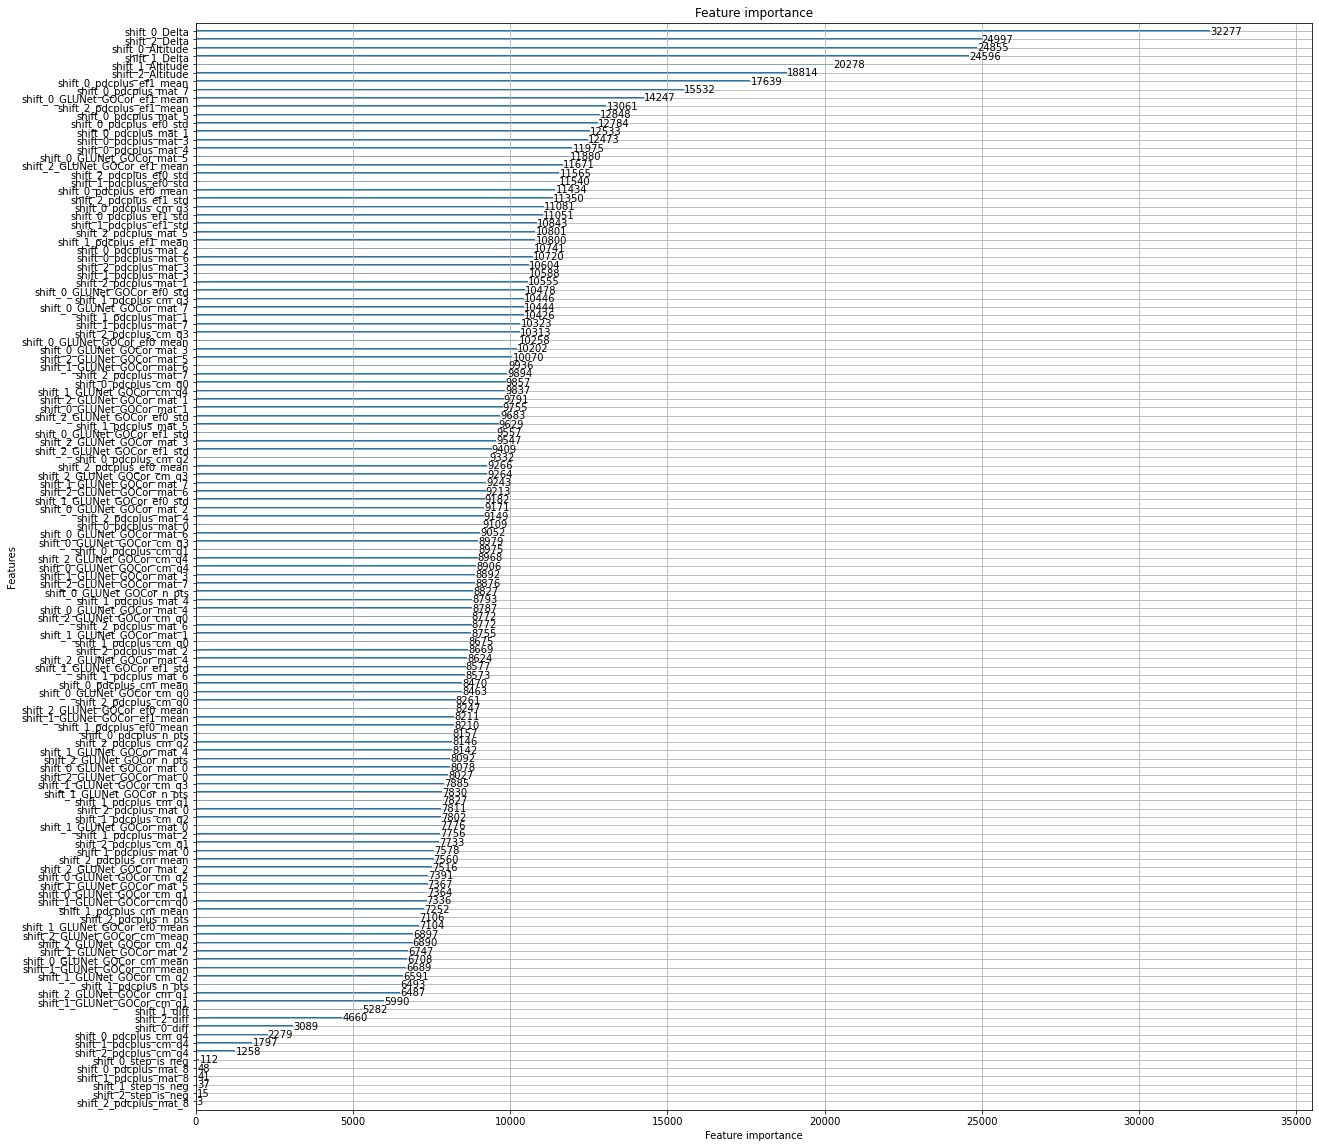

KeyboardInterrupt: 

In [3]:
#!pip install lightgbm 
import lightgbm as lgb
import matplotlib.pyplot as plt

def rmse(x,y):
    return np.sqrt(np.mean(np.square(x-y)))

def get_feature_df(mode):
    sub_names = ['pdcplus']
    cnames = []
    for sub in sub_names:
        cols = list(pd.read_csv(osp.join(ROOT_FOLDER, 'features',sub, f'{mode}.csv')).columns)
        cnames += [sub+ '_' + x for x in cols]
    feat_df = pd.concat([pd.read_csv(osp.join(ROOT_FOLDER, 'features',sub, f'{mode}.csv')) for sub in sub_names],1)
    feat_df.columns = cnames
    return feat_df
def calc_lgb(target_var):
    
    def get_lgb_dataframe(mode):
        feat_df = get_feature_df(mode)
        feat_df['Filename'] = dfs[mode]['Filename']

        if mode == 'trainval':
            flight_df = pd.read_csv(f'./flight/flight_train.csv')
        else:
            flight_df = pd.read_csv(f'./flight/flight_test.csv')
        flight_df['step_is_neg'] = np.array((flight_df['step'].values == -1)).astype(np.float32)

        display(flight_df)

        # Merge
        df = flight_df.copy()
        df = df.merge(feat_df, on='Filename').reset_index(drop=True)

        feat_df = feat_df.drop('Filename',axis=1)

        df_Y = df.loc[:,['North','East']].copy()
        df_X = df.loc[:,['Altitude','Delta', 'diff','step_is_neg'] + list(feat_df.columns) ]
        def shift(df, n):
            #assert n>= 0
            df = df.shift(-n)
            display(df)
            df.columns = [f'shift_{n}_{c}' for c in df.columns]
            return df
        df_X = pd.concat([shift(df_X,i) for i in [0,1,2]], axis=1)
        return df, df_X, df_Y

    train_df, train_df_X, train_df_Y = get_lgb_dataframe('trainval')

    test_df, test_df_X, test_df_Y = get_lgb_dataframe('test')

    N_val = train_df_X.shape[0] // 10
    val_idx = np.arange(train_df_X.shape[0])[-N_val:]#np.where(np.arange(feat_df.shape[0]) < N_val)[0]
    train_idx = np.arange(train_df_X.shape[0])[:-N_val] #= np.where(np.arange(feat_df.shape[0]) >= N_val)[0]

    X_trainval, Y_trainval = train_df_X.copy(), train_df_Y[target_var].copy()

    X_train, Y_train = train_df_X.iloc[train_idx,:].copy(), train_df_Y.iloc[train_idx,:][target_var].copy()
    X_val, Y_val = train_df_X.iloc[val_idx,:].copy(), train_df_Y.iloc[val_idx,:][target_var].copy()

    X_test, Y_test = test_df_X, test_df_Y[target_var].copy()

    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
    lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)


    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'},
        'num_leaves': 61,
        'metric_freq': 10,
        'learning_rate': 0.005,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 5,
        'verbose': 1
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=20000,
                    valid_sets=[lgb_train,lgb_eval])
    fig, ax = plt.subplots(figsize=(20,20))
    lgb.plot_importance(gbm, ax=ax)
    plt.show()
    trainval_pred = gbm.predict(X_trainval, num_iteration=gbm.best_iteration)
    train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
    val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)

    print("Rmse trainval ",rmse(trainval_pred, Y_trainval.values))
    print("Rmse train ",rmse(train_pred, Y_train.values))
    print("Rmse val",rmse(val_pred, Y_val.values))

    test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
    trainval_pred = trainval_pred[np.argsort(train_df['Filename'])] 
    test_pred = test_pred[np.argsort(test_df['Filename'])] 
    
    return trainval_pred, test_pred, gbm

# Train Lightgbm model for North and East predictions separately.
trainval_north, test_north, gbm_north = calc_lgb('North')
trainval_east, test_east, gbm_east = calc_lgb('East')

#print('Saving model...')

In [200]:
display(dfs['trainval'])
print(trainval_north)
print(rmse(dfs['trainval']['North'].values, trainval_north))
#print(np.mean(np.square(trainval_north  - dfs['trainval']['North'].values)))
#print(np.sqrt(np.mean(np.square(trainval_north - dfs['trainval']['North'].values))))

,Filename,Altitude,Delta,North,East
0,00003e3b9e5336685200ae85d21b4f5e.jpg,178.829834,-0.065231,-0.386045,0.929772
1,0001261e2060303a06ba6c64d676d639.jpg,207.921478,-0.080688,0.635584,0.152819
2,0002ac0d783338cfeab0b2bdbd872cda.jpg,178.048431,0.021576,-1.228229,-0.499388
3,0004289ee1c7b8b08c77e19878106ae3.jpg,201.084625,0.505981,-1.739709,-0.699928
4,0004d0b59e19461ff126e3a08a814c33.jpg,187.550201,-0.328156,-0.169798,2.828752
...,...,...,...,...,...
91226,fffe56994e6be696722539f962415cd2.jpg,156.505661,-0.102219,2.143182,-1.334290
91227,fffe9f664c2ddba4a37bcd35936c7422.jpg,176.796066,0.045807,-1.329934,-0.138351
91228,fffee5badc626a2ab8086120712e5639.jpg,173.157288,-0.003067,1.023046,-2.311214
91229,ffffda8ada4827900cbf65fd20281080.jpg,205.024994,0.005096,2.476233,-0.172700


[-0.4056436   0.36803673 -1.29132122 ...  1.00549238  1.90560415
  0.62991655]
0.32382381328085214


In [34]:

PREDICTION_NAME = input("Give a name to this prediction")
pred_folder = osp.join(ROOT_FOLDER,'predictions', PREDICTION_NAME)
os.makedirs(pred_folder,exist_ok=True)

for mode, df_N, df_E in [('trainval', trainval_north, trainval_east),('test',test_north, test_east)]:
    df = pd.DataFrame(index=range(2 * dfs[mode].shape[0]), columns=['Id','Predicted'])
    df['Id'].values[::2] = [f'{fname}:North' for fname in dfs[mode]['Filename'].values] 
    df['Id'].values[1::2] = [f'{fname}:East' for fname in dfs[mode]['Filename'].values] 
    df['Predicted'].values[::2] = df_N
    df['Predicted'].values[1::2] = df_E
    df.to_csv(osp.join(pred_folder,f'{mode}.csv'),index=False)
    
    gbm_north.save_model(osp.join(pred_folder,f'gbm_north.txt'))
    gbm_east.save_model(osp.join(pred_folder,f'gbm_east.txt'))
    
    display(df)
    

Give a name to this predictionSep29_lgb_3


,Id,Predicted
0,00003e3b9e5336685200ae85d21b4f5e.jpg:North,-0.36078
1,00003e3b9e5336685200ae85d21b4f5e.jpg:East,0.908246
2,0001261e2060303a06ba6c64d676d639.jpg:North,0.634716
3,0001261e2060303a06ba6c64d676d639.jpg:East,0.165727
4,0002ac0d783338cfeab0b2bdbd872cda.jpg:North,-1.180424
...,...,...
182457,fffee5badc626a2ab8086120712e5639.jpg:East,-2.33079
182458,ffffda8ada4827900cbf65fd20281080.jpg:North,2.505806
182459,ffffda8ada4827900cbf65fd20281080.jpg:East,-0.137462
182460,fffffe98d0963d27015c198262d97221.jpg:North,0.625929


,Id,Predicted
0,000053b1e684c9e7ea73727b2238ce18.jpg:North,0.011753
1,000053b1e684c9e7ea73727b2238ce18.jpg:East,0.101165
2,00029153d12ae1c9abe59c17ff2e0895.jpg:North,0.896602
3,00029153d12ae1c9abe59c17ff2e0895.jpg:East,-0.977325
4,0006246bee639c7a7b11a08e34dd3cc6.jpg:North,-1.801336
...,...,...
110057,fff9e3be29d11366c43df7b2ae749547.jpg:East,1.125095
110058,fffae68750a8bd5e6ba46b25ce7030de.jpg:North,-0.7269
110059,fffae68750a8bd5e6ba46b25ce7030de.jpg:East,-1.777965
110060,fffaee1d19b93f046ff12095b5c56685.jpg:North,0.490051
